In [22]:
import torch
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from PIL import Image
from cleanvision import Imagelab
import os
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import ssl
from tqdm import tqdm
import timm
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt

Using device: mps
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


100%|██████████| 7909/7909 [00:25<00:00, 316.13it/s]


Issue checks completed. 330 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | odd_size         |           74 |
|  2 | near_duplicates  |            6 |
|  3 | dark             |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | low_information  |            0 |
|  7 | blurry           |            0 |
|  8 | grayscale        |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


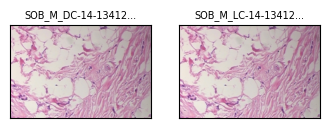

Set: 1


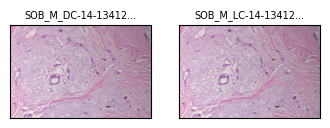

Set: 2


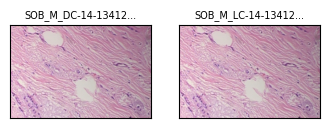

Set: 3


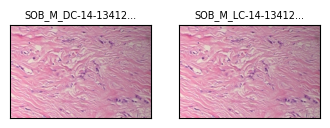

--------------------- odd_size images ----------------------

Number of examples with this issue: 74
Examples representing most severe instances of this issue:



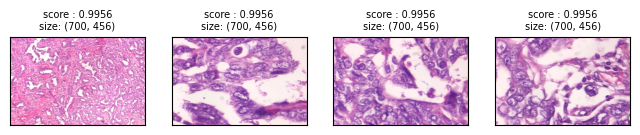

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


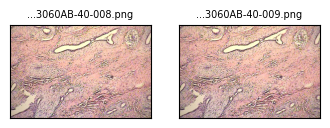

Set: 1


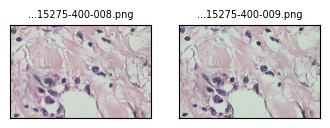

Set: 2


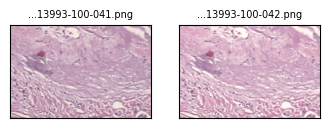

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


100%|██████████| 7579/7579 [00:27<00:00, 280.60it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | dark             |            0 |
|  1 | light            |            0 |
|  2 | odd_aspect_ratio |            0 |
|  3 | low_information  |            0 |
|  4 | blurry           |            0 |
|  5 | grayscale        |            0 |
|  6 | odd_size         |            0 |
|  7 | exact_duplicates |            0 |
|  8 | near_duplicates  |            0 | 



In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")  # Print the selected device

# Load the fold information and extract labels
fold_info = pd.read_csv("Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")

# Select a specific fold
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy().reset_index(drop=True)

imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)  # Get a detailed report

# Identify problematic images (duplicates and odd sizes)
problems = imagelab.issues[["is_exact_duplicates_issue", "is_near_duplicates_issue", "is_odd_size_issue"]]
has_problems = problems.any(axis=1).reset_index().rename(columns={"index": "filename", 0: "has_problems"})

# Ensure filenames match
if not has_problems["filename"].equals(selected_fold_data["filename"]):
    raise ValueError("Filenames in 'has_problems' do not match 'selected_fold_data'")

# Remove problematic images and update the DataFrame
selected_fold_data = selected_fold_data[~has_problems["has_problems"]].copy()  # Create a copy to avoid potential issues

# Save the updated DataFrame to a new CSV file
selected_fold_data.to_csv("cleaned_fold_data.csv", index=False)


# Re-validate the remaining images
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

In [13]:

ssl._create_default_https_context = ssl._create_unverified_context


class BreastCancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.df.iloc[idx, 3]))
        print('--------')
        print(img_path)
        image = Image.open(img_path).convert('RGB')

        # Extract label from filename
        if 'malignant' in self.df.iloc[idx, 3]:
            label = 1
        else:
            label = 0
        print('label:', label)  # Print the extracted label

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# **Define the image directory here**
img_dir = '/Users/mindventor/Desktop/archive/'  # Corrected path

# Assuming 'selected_fold_data' is your DataFrame from previous steps

# Split data into train and validation sets (adjust split ratio as needed)
train_df = selected_fold_data.sample(frac=0.8, random_state=42)
val_df = selected_fold_data.drop(train_df.index)

# Create datasets and dataloaders
train_dataset = BreastCancerDataset(train_df, img_dir, transform=data_transforms['train'])
val_dataset = BreastCancerDataset(val_df, img_dir, transform=data_transforms['val'])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [14]:
model_densenet = models.densenet121(pretrained=True)
model_densenet = model_densenet.to(device)
num_ftrs = model_densenet.classifier.in_features
model_densenet.classifier = torch.nn.Linear(num_ftrs, 2).to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_densenet.parameters(), lr=0.001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  

print("Training DenseNet121...")
for epoch in range(3):
    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tepoch):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model_densenet(inputs)
  # Use model_densenet here
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update learning rate every batch

            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / (i+1))
print("Finished training DenseNet121")

results_densenet = []



label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-100-006.p

Epoch 3:  68%|██████▊   | 129/190 [03:27<01:25,  1.40s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/400X/SOB_M_MC-14-18842-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SO

Epoch 3:  68%|██████▊   | 130/190 [03:28<01:21,  1.35s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-14-1

Epoch 3:  69%|██████▉   | 131/190 [03:29<01:18,  1.32s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-049.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/100X/SOB_M_DC-14-15696-100-003

Epoch 3:  69%|██████▉   | 132/190 [03:30<01:15,  1.30s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/200X/SOB_M_DC-14-1

Epoch 3:  70%|███████   | 133/190 [03:32<01:12,  1.28s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-041.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-20

Epoch 3:  71%|███████   | 134/190 [03:33<01:11,  1.27s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-1341

Epoch 3:  71%|███████   | 135/190 [03:34<01:09,  1.26s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-053.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-055.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-10

Epoch 3:  72%|███████▏  | 136/190 [03:35<01:07,  1.26s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_

Epoch 3:  72%|███████▏  | 137/190 [03:37<01:06,  1.25s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-115

Epoch 3:  73%|███████▎  | 138/190 [03:38<01:05,  1.25s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/400X/SOB_M_DC-14-16601-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-03

Epoch 3:  73%|███████▎  | 139/190 [03:39<01:03,  1.25s/batch, loss=0.256]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/400X/SOB_M_DC-14-8168-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440

Epoch 3:  74%|███████▎  | 140/190 [03:40<01:02,  1.25s/batch, loss=0.256]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/400X/SOB_M_DC-14-2985-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650

Epoch 3:  74%|███████▍  | 141/190 [03:42<01:00,  1.24s/batch, loss=0.256]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-065.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-064.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X/SOB_M_DC-14-16875-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-040.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998

Epoch 3:  75%|███████▍  | 142/190 [03:43<00:59,  1.24s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-009.png
lab

Epoch 3:  75%|███████▌  | 143/190 [03:44<00:58,  1.25s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-0

Epoch 3:  76%|███████▌  | 144/190 [03:45<00:57,  1.25s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-14-19979C-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5

Epoch 3:  76%|███████▋  | 145/190 [03:47<00:55,  1.24s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6

Epoch 3:  77%|███████▋  | 146/190 [03:48<00:54,  1.24s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/S

Epoch 3:  77%|███████▋  | 147/190 [03:49<00:53,  1.24s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X/SOB_B_TA-14-21978AB-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-

Epoch 3:  78%|███████▊  | 148/190 [03:50<00:51,  1.24s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-047.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-

Epoch 3:  78%|███████▊  | 149/190 [03:52<00:51,  1.24s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-014

Epoch 3:  79%|███████▉  | 150/190 [03:53<00:49,  1.24s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-041.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/400X/SOB_M_DC-14-8168-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-067.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-

Epoch 3:  79%|███████▉  | 151/190 [03:54<00:48,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-018.png
l

Epoch 3:  80%|████████  | 152/190 [03:55<00:47,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/40X/SOB_B_TA-14-15275-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_TA-14-15275-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-1

Epoch 3:  81%|████████  | 153/190 [03:57<00:46,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-022.png
labe

Epoch 3:  81%|████████  | 154/190 [03:58<00:44,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-044.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-

Epoch 3:  82%|████████▏ | 155/190 [03:59<00:43,  1.24s/batch, loss=0.252]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-946

Epoch 3:  82%|████████▏ | 156/190 [04:00<00:42,  1.25s/batch, loss=0.252]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-078.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X/SOB_M_MC-14-12773-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-2

Epoch 3:  83%|████████▎ | 157/190 [04:01<00:41,  1.25s/batch, loss=0.252]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-040.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-017.

Epoch 3:  83%|████████▎ | 158/190 [04:03<00:39,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-076.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-1557

Epoch 3:  84%|████████▎ | 159/190 [04:04<00:38,  1.26s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/400X/SOB_M_DC-14-16601-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-0

Epoch 3:  84%|████████▍ | 160/190 [04:05<00:37,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-046.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-1

Epoch 3:  85%|████████▍ | 161/190 [04:07<00:36,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-

Epoch 3:  85%|████████▌ | 162/190 [04:08<00:35,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-021.png


Epoch 3:  86%|████████▌ | 163/190 [04:09<00:33,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X/SOB_M_MC-14-19979C-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-1

Epoch 3:  86%|████████▋ | 164/190 [04:10<00:32,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-001

Epoch 3:  87%|████████▋ | 165/190 [04:12<00:31,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X/SOB_M_DC-14-11031-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X/SOB_B_TA-14-19854C-400-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-11520-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-02

Epoch 3:  87%|████████▋ | 166/190 [04:13<00:29,  1.25s/batch, loss=0.255]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X/SOB_M_DC-14-6241-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/100X/SOB_M_DC-14-4364-10

Epoch 3:  88%|████████▊ | 167/190 [04:14<00:28,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_TA-14-15275-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_DC-14-2985-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-0

Epoch 3:  88%|████████▊ | 168/190 [04:15<00:27,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-026.png
l

Epoch 3:  89%|████████▉ | 169/190 [04:17<00:26,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-2

Epoch 3:  89%|████████▉ | 170/190 [04:18<00:25,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/400X/SOB_M_MC-14-18842-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/

Epoch 3:  90%|█████████ | 171/190 [04:19<00:23,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-0

Epoch 3:  91%|█████████ | 172/190 [04:20<00:22,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-036.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-01

Epoch 3:  91%|█████████ | 173/190 [04:22<00:21,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X/SOB_M_DC-14-5694-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-40

Epoch 3:  92%|█████████▏| 174/190 [04:23<00:20,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-043.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-

Epoch 3:  92%|█████████▏| 175/190 [04:24<00:18,  1.26s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-015.p

Epoch 3:  93%|█████████▎| 176/190 [04:25<00:17,  1.26s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-14-17915-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-015.p

Epoch 3:  93%|█████████▎| 177/190 [04:27<00:16,  1.26s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-14-19979C-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-0

Epoch 3:  94%|█████████▎| 178/190 [04:28<00:15,  1.26s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-2

Epoch 3:  94%|█████████▍| 179/190 [04:29<00:13,  1.26s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16

Epoch 3:  95%|█████████▍| 180/190 [04:30<00:12,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-01

Epoch 3:  95%|█████████▌| 181/190 [04:32<00:11,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC-15-190EF-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-14-13418DE-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440

Epoch 3:  96%|█████████▌| 182/190 [04:33<00:10,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X/SOB_M_DC-14-5695-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400

Epoch 3:  96%|█████████▋| 183/190 [04:34<00:08,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400

Epoch 3:  97%|█████████▋| 184/190 [04:35<00:07,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X/SOB_M_DC-14-14015-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/200X/SOB_M_MC-14-19979C-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M

Epoch 3:  97%|█████████▋| 185/190 [04:37<00:06,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-040.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-00

Epoch 3:  98%|█████████▊| 186/190 [04:38<00:05,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-

Epoch 3:  98%|█████████▊| 187/190 [04:39<00:03,  1.25s/batch, loss=0.254]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146

Epoch 3:  99%|█████████▉| 188/190 [04:40<00:02,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC

Epoch 3:  99%|█████████▉| 189/190 [04:42<00:01,  1.25s/batch, loss=0.253]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_

Epoch 3: 100%|██████████| 190/190 [04:42<00:00,  1.49s/batch, loss=0.254]

Finished training DenseNet121


In [15]:
model_resnet = models.resnet18(pretrained=True)
model_resnet = model_resnet.to(device)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = torch.nn.Linear(num_ftrs, 2).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  

print("Training Resnet...")
for epoch in range(3):
    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tepoch):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model_resnet(inputs)
  # Use model_densenet here
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update learning rate every batch

            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / (i+1))
print("Finished training DenseNet121")
# Store the results
results_resnet = []

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-039.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X/SOB_M_MC-14-13418DE-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-

Epoch 3:  34%|███▎      | 64/190 [01:10<01:29,  1.41batch/s, loss=0.288]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-1557

Epoch 3:  34%|███▍      | 65/190 [01:10<01:27,  1.43batch/s, loss=0.287]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X/SOB_M_MC-14-13418DE-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-017.png
la

Epoch 3:  35%|███▍      | 66/190 [01:11<01:26,  1.43batch/s, loss=0.288]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-341

Epoch 3:  35%|███▌      | 67/190 [01:12<01:25,  1.44batch/s, loss=0.289]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-14-19979C-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/100X/SOB_M_DC-14-4364-

Epoch 3:  36%|███▌      | 68/190 [01:12<01:24,  1.44batch/s, loss=0.29] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X/SOB_B_F-14-23060CD-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-00

Epoch 3:  36%|███▋      | 69/190 [01:13<01:24,  1.43batch/s, loss=0.29]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X/SOB_M_MC-14-13418DE-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15

Epoch 3:  37%|███▋      | 70/190 [01:14<01:24,  1.42batch/s, loss=0.294]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696

Epoch 3:  37%|███▋      | 71/190 [01:14<01:23,  1.42batch/s, loss=0.293]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-040.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650

Epoch 3:  38%|███▊      | 72/190 [01:15<01:22,  1.42batch/s, loss=0.294]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-

Epoch 3:  38%|███▊      | 73/190 [01:16<01:22,  1.42batch/s, loss=0.293]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-

Epoch 3:  39%|███▉      | 74/190 [01:17<01:22,  1.41batch/s, loss=0.293]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X/SOB_M_MC-14-12773-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-

Epoch 3:  39%|███▉      | 75/190 [01:17<01:20,  1.42batch/s, loss=0.292]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/100X/SOB_M_DC-14-16448-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-012.png


Epoch 3:  40%|████      | 76/190 [01:18<01:20,  1.42batch/s, loss=0.291]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-037.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031

Epoch 3:  41%|████      | 77/190 [01:19<01:18,  1.43batch/s, loss=0.29] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-003.png
label: 0
--------
/Users/mindv

Epoch 3:  41%|████      | 78/190 [01:19<01:17,  1.44batch/s, loss=0.29]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-

Epoch 3:  42%|████▏     | 79/190 [01:20<01:17,  1.44batch/s, loss=0.292]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-031.p

Epoch 3:  42%|████▏     | 80/190 [01:21<01:16,  1.44batch/s, loss=0.291]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-002.p

Epoch 3:  43%|████▎     | 81/190 [01:21<01:15,  1.44batch/s, loss=0.292]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-20

Epoch 3:  43%|████▎     | 82/190 [01:22<01:15,  1.44batch/s, loss=0.291]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-059.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-017.png
labe

Epoch 3:  44%|████▎     | 83/190 [01:23<01:14,  1.44batch/s, loss=0.291]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/200X/SOB_M_DC-14-8168-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695

Epoch 3:  44%|████▍     | 84/190 [01:24<01:13,  1.44batch/s, loss=0.293]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-13413-400-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-031.

Epoch 3:  45%|████▍     | 85/190 [01:24<01:13,  1.43batch/s, loss=0.294]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-

Epoch 3:  45%|████▌     | 86/190 [01:25<01:12,  1.43batch/s, loss=0.293]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-40

Epoch 3:  46%|████▌     | 87/190 [01:26<01:11,  1.43batch/s, loss=0.292]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-

Epoch 3:  46%|████▋     | 88/190 [01:26<01:11,  1.43batch/s, loss=0.292]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-055.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-

Epoch 3:  47%|████▋     | 89/190 [01:27<01:10,  1.43batch/s, loss=0.293]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-0

Epoch 3:  47%|████▋     | 90/190 [01:28<01:09,  1.43batch/s, loss=0.294]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X/SOB_B_A-14-29960CD-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-014.png
l

Epoch 3:  48%|████▊     | 91/190 [01:28<01:08,  1.44batch/s, loss=0.295]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-055.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998

Epoch 3:  48%|████▊     | 92/190 [01:29<01:08,  1.44batch/s, loss=0.296]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-156

Epoch 3:  49%|████▉     | 93/190 [01:30<01:07,  1.44batch/s, loss=0.296]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-

Epoch 3:  49%|████▉     | 94/190 [01:30<01:06,  1.44batch/s, loss=0.296]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X/SOB_M_MC-14-19979C-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-0

Epoch 3:  50%|█████     | 95/190 [01:31<01:05,  1.45batch/s, loss=0.296]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X/SOB_M_DC-14-16448-200-011.png
label: 1
-

Epoch 3:  51%|█████     | 96/190 [01:32<01:04,  1.45batch/s, loss=0.297]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-039.p

Epoch 3:  51%|█████     | 97/190 [01:33<01:04,  1.45batch/s, loss=0.299]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-038.png
label

Epoch 3:  52%|█████▏    | 98/190 [01:33<01:03,  1.45batch/s, loss=0.299]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-072.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X/SOB_M_MC-14-19979C-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X/SOB_B_A-14-29960CD-100-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-

Epoch 3:  52%|█████▏    | 99/190 [01:34<01:02,  1.46batch/s, loss=0.3]  

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901

Epoch 3:  53%|█████▎    | 100/190 [01:35<01:02,  1.44batch/s, loss=0.3]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-044.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-2

Epoch 3:  53%|█████▎    | 101/190 [01:35<01:01,  1.44batch/s, loss=0.302]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-10

Epoch 3:  54%|█████▎    | 102/190 [01:36<01:01,  1.44batch/s, loss=0.303]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-036.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001

Epoch 3:  54%|█████▍    | 103/190 [01:37<01:00,  1.44batch/s, loss=0.304]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/40X/SOB_B_TA-14-15275-40-009.png

Epoch 3:  55%|█████▍    | 104/190 [01:37<00:59,  1.44batch/s, loss=0.304]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-1

Epoch 3:  55%|█████▌    | 105/190 [01:38<00:59,  1.43batch/s, loss=0.305]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/100X/SOB_M_DC-14-4364-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-02

Epoch 3:  56%|█████▌    | 106/190 [01:39<00:58,  1.43batch/s, loss=0.303]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456

Epoch 3:  56%|█████▋    | 107/190 [01:40<00:57,  1.44batch/s, loss=0.305]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-042.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11

Epoch 3:  57%|█████▋    | 108/190 [01:40<00:57,  1.44batch/s, loss=0.304]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/400X/SOB_M_DC-14-4364-400-004.png

Epoch 3:  57%|█████▋    | 109/190 [01:41<00:56,  1.44batch/s, loss=0.304]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-14-19979C-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629

Epoch 3:  58%|█████▊    | 110/190 [01:42<00:55,  1.44batch/s, loss=0.305]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/40X/SOB_M_DC-14-16448-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X/SOB_M_PC-15-190EF-40

Epoch 3:  58%|█████▊    | 111/190 [01:42<00:55,  1.43batch/s, loss=0.303]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/200X/SOB_M_DC-14-2985-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C

Epoch 3:  59%|█████▉    | 112/190 [01:43<00:54,  1.42batch/s, loss=0.304]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-021.png
labe

Epoch 3:  59%|█████▉    | 113/190 [01:44<00:54,  1.42batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/200X/SOB_M_PC-14-15687B-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-

Epoch 3:  60%|██████    | 114/190 [01:44<00:53,  1.43batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-

Epoch 3:  61%|██████    | 115/190 [01:45<00:52,  1.44batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/40X/SOB_M_DC-14-8168-

Epoch 3:  61%|██████    | 116/190 [01:46<00:51,  1.44batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-

Epoch 3:  62%|██████▏   | 117/190 [01:47<00:50,  1.43batch/s, loss=0.307]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-004

Epoch 3:  62%|██████▏   | 118/190 [01:47<00:50,  1.43batch/s, loss=0.307]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-003.pn

Epoch 3:  63%|██████▎   | 119/190 [01:48<00:49,  1.44batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-0

Epoch 3:  63%|██████▎   | 120/190 [01:49<00:48,  1.44batch/s, loss=0.308]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-1

Epoch 3:  64%|██████▎   | 121/190 [01:49<00:47,  1.44batch/s, loss=0.308]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/200X/SOB_M_MC-14-19979-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X/SOB_B_F-14-23060CD-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-1944

Epoch 3:  64%|██████▍   | 122/190 [01:50<00:47,  1.44batch/s, loss=0.307]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100

Epoch 3:  65%|██████▍   | 123/190 [01:51<00:46,  1.43batch/s, loss=0.307]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X/SOB_M_DC-14-17915-100-007.p

Epoch 3:  65%|██████▌   | 124/190 [01:51<00:46,  1.43batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-074.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X/SOB_B_F-14-23060CD-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_DC-14-16601-200-0

Epoch 3:  66%|██████▌   | 125/190 [01:52<00:45,  1.43batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-1

Epoch 3:  66%|██████▋   | 126/190 [01:53<00:44,  1.44batch/s, loss=0.305]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-14-17915-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-039.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-014.png
lab

Epoch 3:  67%|██████▋   | 127/190 [01:53<00:43,  1.43batch/s, loss=0.305]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X/SOB_M_DC-14-16448-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-

Epoch 3:  67%|██████▋   | 128/190 [01:54<00:43,  1.44batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-0

Epoch 3:  68%|██████▊   | 129/190 [01:55<00:42,  1.43batch/s, loss=0.307]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X/SOB_M_PC-15-190EF-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_

Epoch 3:  68%|██████▊   | 130/190 [01:56<00:41,  1.43batch/s, loss=0.308]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2

Epoch 3:  69%|██████▉   | 131/190 [01:56<00:41,  1.43batch/s, loss=0.307]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-

Epoch 3:  69%|██████▉   | 132/190 [01:57<00:40,  1.43batch/s, loss=0.307]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-0

Epoch 3:  70%|███████   | 133/190 [01:58<00:40,  1.42batch/s, loss=0.306]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-040.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_TA-14-15275-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-002.png
lab

Epoch 3:  71%|███████   | 134/190 [01:58<00:39,  1.42batch/s, loss=0.309]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X/SOB_B_F-14-23060CD-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC-15-190E

Epoch 3:  71%|███████   | 135/190 [01:59<00:38,  1.42batch/s, loss=0.308]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X/SOB_B_A-14-29960CD-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-050.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287

Epoch 3:  72%|███████▏  | 136/190 [02:00<00:38,  1.42batch/s, loss=0.308]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_

Epoch 3:  72%|███████▏  | 137/190 [02:00<00:37,  1.42batch/s, loss=0.308]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X/SOB_M_DC-14-5695-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-01

Epoch 3:  73%|███████▎  | 138/190 [02:01<00:36,  1.42batch/s, loss=0.31] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-14-17915-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F

Epoch 3:  73%|███████▎  | 139/190 [02:02<00:36,  1.41batch/s, loss=0.31]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/400X/SOB_M_DC-14-4364-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-015.png
label:

Epoch 3:  74%|███████▎  | 140/190 [02:03<00:35,  1.41batch/s, loss=0.311]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-038.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614

Epoch 3:  74%|███████▍  | 141/190 [02:03<00:34,  1.41batch/s, loss=0.311]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X/SOB_M_DC-14-16448-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X/SOB_M_MC-14-134

Epoch 3:  75%|███████▍  | 142/190 [02:04<00:33,  1.42batch/s, loss=0.31] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-025

Epoch 3:  75%|███████▌  | 143/190 [02:05<00:33,  1.42batch/s, loss=0.309]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-062.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400

Epoch 3:  76%|███████▌  | 144/190 [02:05<00:32,  1.42batch/s, loss=0.31] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-010.png
label: 0

Epoch 3:  76%|███████▋  | 145/190 [02:06<00:31,  1.41batch/s, loss=0.31]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-1

Epoch 3:  77%|███████▋  | 146/190 [02:07<00:31,  1.41batch/s, loss=0.31]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-044.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197

Epoch 3:  77%|███████▋  | 147/190 [02:08<00:30,  1.41batch/s, loss=0.31]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/40X/SOB_B_F-14-23060AB-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-014.png
label:

Epoch 3:  78%|███████▊  | 148/190 [02:08<00:29,  1.41batch/s, loss=0.31]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-044.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-045.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X/SOB_M_DC-14-6241-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF

Epoch 3:  78%|███████▊  | 149/190 [02:09<00:29,  1.41batch/s, loss=0.309]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-

Epoch 3:  79%|███████▉  | 150/190 [02:10<00:28,  1.41batch/s, loss=0.311]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-816

Epoch 3:  79%|███████▉  | 151/190 [02:10<00:27,  1.41batch/s, loss=0.311]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X/SOB_M_DC-14-14926-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-024.png
label:

Epoch 3:  80%|████████  | 152/190 [02:11<00:26,  1.41batch/s, loss=0.312]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X/SOB_B_A-14-29960CD-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X/SOB_M_DC-14-14926-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-03

Epoch 3:  81%|████████  | 153/190 [02:12<00:26,  1.40batch/s, loss=0.312]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-048.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X/SOB_M_MC-14-10147-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-036.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-059.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-030.

Epoch 3:  81%|████████  | 154/190 [02:13<00:26,  1.38batch/s, loss=0.313]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X/SOB_M_DC-14-3909-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-02

Epoch 3:  82%|████████▏ | 155/190 [02:13<00:25,  1.37batch/s, loss=0.314]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-018

Epoch 3:  82%|████████▏ | 156/190 [02:14<00:25,  1.36batch/s, loss=0.314]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X/SOB_B_TA-14-19854C-400-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/200X/SOB_M_PC-14-15687B-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-0

Epoch 3:  83%|████████▎ | 157/190 [02:15<00:24,  1.36batch/s, loss=0.313]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16

Epoch 3:  83%|████████▎ | 158/190 [02:16<00:23,  1.37batch/s, loss=0.312]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-

Epoch 3:  84%|████████▎ | 159/190 [02:16<00:22,  1.37batch/s, loss=0.313]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-13413-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-038.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14

Epoch 3:  84%|████████▍ | 160/190 [02:17<00:21,  1.38batch/s, loss=0.313]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-043.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-023.png
l

Epoch 3:  85%|████████▍ | 161/190 [02:18<00:20,  1.38batch/s, loss=0.315]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/40X/SOB_M_DC-14-15792-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-011.png
l

Epoch 3:  85%|████████▌ | 162/190 [02:18<00:20,  1.38batch/s, loss=0.314]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/40X/SOB_M_LC-14-12204-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-020.png
label

Epoch 3:  86%|████████▌ | 163/190 [02:19<00:19,  1.38batch/s, loss=0.313]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/200X/SOB_M_PC-14-15687B-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_

Epoch 3:  86%|████████▋ | 164/190 [02:20<00:18,  1.39batch/s, loss=0.313]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-047.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-03

Epoch 3:  87%|████████▋ | 165/190 [02:21<00:18,  1.38batch/s, loss=0.314]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/400X/SOB_B_TA-14-15275-400-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/400X/SOB_M_DC-14-16336-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-

Epoch 3:  87%|████████▋ | 166/190 [02:21<00:17,  1.38batch/s, loss=0.314]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-016.png

Epoch 3:  88%|████████▊ | 167/190 [02:22<00:16,  1.38batch/s, loss=0.314]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-052.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC

Epoch 3:  88%|████████▊ | 168/190 [02:23<00:15,  1.38batch/s, loss=0.315]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-028.png
labe

Epoch 3:  89%|████████▉ | 169/190 [02:23<00:15,  1.38batch/s, loss=0.316]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X/SOB_B_F-14-23060CD-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-

Epoch 3:  89%|████████▉ | 170/190 [02:24<00:14,  1.39batch/s, loss=0.316]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/40X/SOB_M_DC-14-15792-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X/SOB_M_PC-15-190EF-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-00

Epoch 3:  90%|█████████ | 171/190 [02:25<00:13,  1.39batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-041.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_

Epoch 3:  91%|█████████ | 172/190 [02:26<00:12,  1.39batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/40X/SOB_B_F-14-23060AB-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-006

Epoch 3:  91%|█████████ | 173/190 [02:26<00:12,  1.39batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/40X/SOB_M_DC-14-15792-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC-15-1

Epoch 3:  92%|█████████▏| 174/190 [02:27<00:11,  1.39batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-011.png
lab

Epoch 3:  92%|█████████▏| 175/190 [02:28<00:10,  1.39batch/s, loss=0.316]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/200X/SOB_M_MC-14-18842-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-074.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-1

Epoch 3:  93%|█████████▎| 176/190 [02:29<00:10,  1.39batch/s, loss=0.316]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-057.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-1

Epoch 3:  93%|█████████▎| 177/190 [02:29<00:09,  1.39batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-036.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241

Epoch 3:  94%|█████████▎| 178/190 [02:30<00:08,  1.39batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-053.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M

Epoch 3:  94%|█████████▍| 179/190 [02:31<00:07,  1.39batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X/SOB_B_F-14-23060CD-40-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-004.png

Epoch 3:  95%|█████████▍| 180/190 [02:31<00:07,  1.38batch/s, loss=0.318]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X/SOB_M_MC-14-13418DE-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X/SOB_B_A-14-29960CD-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-0

Epoch 3:  95%|█████████▌| 181/190 [02:32<00:06,  1.38batch/s, loss=0.318]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-015.p

Epoch 3:  96%|█████████▌| 182/190 [02:33<00:05,  1.38batch/s, loss=0.318]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-033.png
label: 1

Epoch 3:  96%|█████████▋| 183/190 [02:34<00:05,  1.38batch/s, loss=0.318]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X/SOB_M_DC-14-14926-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_

Epoch 3:  97%|█████████▋| 184/190 [02:34<00:04,  1.38batch/s, loss=0.318]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-002.

Epoch 3:  97%|█████████▋| 185/190 [02:35<00:03,  1.37batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-

Epoch 3:  98%|█████████▊| 186/190 [02:36<00:02,  1.38batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-010.png
label:

Epoch 3:  98%|█████████▊| 187/190 [02:36<00:02,  1.38batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-

Epoch 3:  99%|█████████▉| 188/190 [02:37<00:01,  1.38batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X/SOB_M_DC-14-11031-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-008.p

Epoch 3:  99%|█████████▉| 189/190 [02:38<00:00,  1.37batch/s, loss=0.317]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-1557

Epoch 3: 100%|██████████| 190/190 [02:38<00:00,  1.20batch/s, loss=0.316]

label: 1
Finished training DenseNet121


In [16]:
model_efficientnet = models.efficientnet_b0(pretrained=True)
model_efficientnet = model_efficientnet.to(device)
num_ftrs = model_efficientnet.classifier[-1].in_features
model_efficientnet.classifier[-1] = torch.nn.Linear(num_ftrs, 2).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficientnet.parameters(), lr=0.001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  
print("Training EfficientNet...")
for epoch in range(3):
    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tepoch):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_efficientnet(inputs)
  # Use model_densenet here
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Update learning rate every batch

            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / (i+1))
print("Finished training Efficientnet")
# Store the results
results_efficientnet = []


Epoch 2:  31%|███       | 58/190 [00:53<02:08,  1.02batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X/SOB_M_MC-14-12773-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_M

Epoch 2:  31%|███       | 59/190 [00:54<02:05,  1.04batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-

Epoch 2:  32%|███▏      | 60/190 [00:54<02:02,  1.06batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X/SOB_B_F-14-23060CD-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-010.png
l

Epoch 2:  32%|███▏      | 61/190 [00:55<02:01,  1.06batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-3411F-40-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-10

Epoch 2:  33%|███▎      | 62/190 [00:56<01:59,  1.07batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X/SOB_M_PC-15-190EF-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X/SOB_B_A-14-29960CD-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/100X/SOB_M_DC-14-1660

Epoch 2:  33%|███▎      | 63/190 [00:57<01:57,  1.08batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-029.pn

Epoch 2:  34%|███▎      | 64/190 [00:58<01:55,  1.09batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998C

Epoch 2:  34%|███▍      | 65/190 [00:59<01:54,  1.09batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-038.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200

Epoch 2:  35%|███▍      | 66/190 [01:00<01:54,  1.08batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-006.png


Epoch 2:  35%|███▌      | 67/190 [01:01<01:53,  1.08batch/s, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SO

Epoch 2:  36%|███▌      | 68/190 [01:02<01:51,  1.09batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_DC-14-2985-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-

Epoch 2:  36%|███▋      | 69/190 [01:03<01:50,  1.10batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X/SOB_M_MC-14-10147-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X/SOB_M_DC-14-10926-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X/SOB_M_DC-14-17915-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-

Epoch 2:  37%|███▋      | 70/190 [01:04<01:48,  1.10batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-043.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-062.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_P

Epoch 2:  37%|███▋      | 71/190 [01:04<01:47,  1.11batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-056.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-1

Epoch 2:  38%|███▊      | 72/190 [01:05<01:46,  1.11batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X/SOB_M_MC-14-

Epoch 2:  38%|███▊      | 73/190 [01:06<01:45,  1.11batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/400X/SOB_M_DC-14-4364-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/40X/SOB_M_DC-14-15792-4

Epoch 2:  39%|███▉      | 74/190 [01:07<01:44,  1.11batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200

Epoch 2:  39%|███▉      | 75/190 [01:08<01:45,  1.09batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/400X/SOB_M_MC-14-1

Epoch 2:  40%|████      | 76/190 [01:09<01:43,  1.10batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-074.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-251

Epoch 2:  41%|████      | 77/190 [01:10<01:43,  1.10batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X/SOB_M_DC-14-16875-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100

Epoch 2:  41%|████      | 78/190 [01:11<01:42,  1.10batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-078.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-11520-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SO

Epoch 2:  42%|████▏     | 79/190 [01:12<01:42,  1.09batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-14-19979C-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-4

Epoch 2:  42%|████▏     | 80/190 [01:13<01:40,  1.09batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-022.png
l

Epoch 2:  43%|████▎     | 81/190 [01:14<01:39,  1.10batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-053.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-

Epoch 2:  43%|████▎     | 82/190 [01:14<01:37,  1.11batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-049.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-0

Epoch 2:  44%|████▎     | 83/190 [01:15<01:37,  1.09batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-041.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC

Epoch 2:  44%|████▍     | 84/190 [01:16<01:36,  1.10batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-1

Epoch 2:  45%|████▍     | 85/190 [01:17<01:35,  1.09batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-058.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X/SOB_B_F-14-23060CD-40-012.png
la

Epoch 2:  45%|████▌     | 86/190 [01:18<01:34,  1.10batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-038.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/40X/SOB_M_DC-14-16875-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196-100-008

Epoch 2:  46%|████▌     | 87/190 [01:19<01:33,  1.11batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200

Epoch 2:  46%|████▋     | 88/190 [01:20<01:31,  1.11batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-

Epoch 2:  47%|████▋     | 89/190 [01:21<01:31,  1.10batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-027.p

Epoch 2:  47%|████▋     | 90/190 [01:22<01:30,  1.10batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X/SOB_M_DC-14-16875-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-161

Epoch 2:  48%|████▊     | 91/190 [01:23<01:30,  1.09batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X/SOB_M_DC-14-14926-400-005.

Epoch 2:  48%|████▊     | 92/190 [01:24<01:29,  1.10batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/40X/SOB_M_DC-14-16601-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X/SOB_M_DC-14-16875-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-140

Epoch 2:  49%|████▉     | 93/190 [01:24<01:28,  1.10batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40

Epoch 2:  49%|████▉     | 94/190 [01:25<01:27,  1.10batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-044.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/40X/SOB_M_DC-14-16601-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-020.pn

Epoch 2:  50%|█████     | 95/190 [01:26<01:25,  1.11batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/200X/SOB_M_DC-14-16875-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD

Epoch 2:  51%|█████     | 96/190 [01:27<01:24,  1.11batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-028.png
l

Epoch 2:  51%|█████     | 97/190 [01:28<01:25,  1.09batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-1

Epoch 2:  52%|█████▏    | 98/190 [01:29<01:23,  1.10batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/100X/SOB_M_DC-14-15696-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-02

Epoch 2:  52%|█████▏    | 99/190 [01:30<01:23,  1.09batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-062.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440

Epoch 2:  53%|█████▎    | 100/190 [01:31<01:22,  1.10batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/40X/SOB_M_DC-14-16448-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-017.pn

Epoch 2:  53%|█████▎    | 101/190 [01:32<01:21,  1.10batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X/SOB_M

Epoch 2:  54%|█████▎    | 102/190 [01:33<01:19,  1.10batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-11520-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X/SOB_M_MC-14-12773-400-018

Epoch 2:  54%|█████▍    | 103/190 [01:34<01:18,  1.11batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-030.png
label: 

Epoch 2:  55%|█████▍    | 104/190 [01:34<01:17,  1.11batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X/SOB_B_TA-14-21978AB-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-033.png
l

Epoch 2:  55%|█████▌    | 105/190 [01:35<01:16,  1.11batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-

Epoch 2:  56%|█████▌    | 106/190 [01:36<01:15,  1.11batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/400X/SOB_B_TA-14-21978AB-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-1618

Epoch 2:  56%|█████▋    | 107/190 [01:37<01:15,  1.10batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X/SOB_B_TA-14-21978AB-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-011.pn

Epoch 2:  57%|█████▋    | 108/190 [01:38<01:14,  1.10batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-061.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-012.png
l

Epoch 2:  57%|█████▋    | 109/190 [01:39<01:13,  1.11batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-038.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-10

Epoch 2:  58%|█████▊    | 110/190 [01:40<01:12,  1.11batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-014.

Epoch 2:  58%|█████▊    | 111/190 [01:41<01:12,  1.09batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X/SOB_M_DC-14-3909-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_

Epoch 2:  59%|█████▉    | 112/190 [01:42<01:12,  1.08batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-002.png

Epoch 2:  59%|█████▉    | 113/190 [01:43<01:10,  1.09batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372

Epoch 2:  60%|██████    | 114/190 [01:44<01:09,  1.09batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/200X/SOB_M_DC-14-16875-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/100X/SOB_M_DC-14-4364-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/400X/SOB_M_DC-14-8168

Epoch 2:  61%|██████    | 115/190 [01:44<01:08,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-069.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_M

Epoch 2:  61%|██████    | 116/190 [01:45<01:06,  1.11batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X/SOB_M_MC-14-18842D-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-1

Epoch 2:  62%|██████▏   | 117/190 [01:46<01:06,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/200X/SOB_M_DC-14-8168-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14

Epoch 2:  62%|██████▏   | 118/190 [01:47<01:05,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-

Epoch 2:  63%|██████▎   | 119/190 [01:48<01:04,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/400X/SOB_M_MC-14-18842-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-13413-400-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/100X/SOB_M_DC-14-16

Epoch 2:  63%|██████▎   | 120/190 [01:49<01:03,  1.11batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-

Epoch 2:  64%|██████▎   | 121/190 [01:50<01:02,  1.11batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-040.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-003.png
label

Epoch 2:  64%|██████▍   | 122/190 [01:51<01:02,  1.09batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-005

Epoch 2:  65%|██████▍   | 123/190 [01:52<01:01,  1.09batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-

Epoch 2:  65%|██████▌   | 124/190 [01:53<01:00,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B

Epoch 2:  66%|██████▌   | 125/190 [01:54<00:58,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-14-13418DE-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/400X/SOB_

Epoch 2:  66%|██████▋   | 126/190 [01:54<00:57,  1.11batch/s, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-010.png
l

Epoch 2:  67%|██████▋   | 127/190 [01:55<00:57,  1.10batch/s, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X/SOB_M_DC-14-10926-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-1494

Epoch 2:  67%|██████▋   | 128/190 [01:56<00:56,  1.10batch/s, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/100X/SOB_B_TA-14-15275-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X/SOB_M_DC-14-10926-40-006.png

Epoch 2:  68%|██████▊   | 129/190 [01:57<00:55,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-206

Epoch 2:  68%|██████▊   | 130/190 [01:58<00:54,  1.10batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/200X/SOB_M_MC-14-19979C-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-1

Epoch 2:  69%|██████▉   | 131/190 [01:59<00:53,  1.11batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_DC-14-16601-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/40X/SOB_B_TA-14-15275-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X/SOB_M_DC-14-16875-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-004.

Epoch 2:  69%|██████▉   | 132/190 [02:00<00:52,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/200X/SOB_M_DC-14-8168-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-068.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-199

Epoch 2:  70%|███████   | 133/190 [02:01<00:51,  1.10batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-013.p

Epoch 2:  71%|███████   | 134/190 [02:02<00:50,  1.11batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X/SOB_B_TA-14-19854C-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-14-17915-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-179

Epoch 2:  71%|███████   | 135/190 [02:03<00:49,  1.11batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-034.pn

Epoch 2:  72%|███████▏  | 136/190 [02:04<00:50,  1.07batch/s, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/100X/SOB_M_DC-14-16601-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-

Epoch 2:  72%|███████▏  | 137/190 [02:04<00:48,  1.08batch/s, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X/SOB_B_PT-14-29315EF-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-2

Epoch 2:  73%|███████▎  | 138/190 [02:05<00:47,  1.09batch/s, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-029.png
l

Epoch 2:  73%|███████▎  | 139/190 [02:06<00:48,  1.05batch/s, loss=0.231]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-016.png
l

Epoch 2:  74%|███████▎  | 140/190 [02:07<00:49,  1.02batch/s, loss=0.231]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-0

Epoch 2:  74%|███████▍  | 141/190 [02:09<00:49,  1.00s/batch, loss=0.231]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-041.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100

Epoch 2:  75%|███████▍  | 142/190 [02:10<00:48,  1.02s/batch, loss=0.231]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/40X/SOB_B_F-14-23060AB-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-022

Epoch 2:  75%|███████▌  | 143/190 [02:11<00:50,  1.08s/batch, loss=0.23] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-041.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-

Epoch 2:  76%|███████▌  | 144/190 [02:12<00:51,  1.12s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-014

Epoch 2:  76%|███████▋  | 145/190 [02:14<00:56,  1.25s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-20

Epoch 2:  77%|███████▋  | 146/190 [02:15<00:53,  1.22s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X/SOB_M_DC-14-11031-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-10

Epoch 2:  77%|███████▋  | 147/190 [02:16<00:51,  1.20s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-400-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/40X/SOB_M_LC-14-12204-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X/SOB_M_DC-14-17915-100-004.png
labe

Epoch 2:  78%|███████▊  | 148/190 [02:17<00:51,  1.22s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/200X/SOB_M_PC-14-15687B-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-065.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14

Epoch 2:  78%|███████▊  | 149/190 [02:18<00:48,  1.19s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-052.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-

Epoch 2:  79%|███████▉  | 150/190 [02:19<00:45,  1.14s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-044.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-025

Epoch 2:  79%|███████▉  | 151/190 [02:20<00:43,  1.12s/batch, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-012.png

Epoch 2:  80%|████████  | 152/190 [02:21<00:42,  1.11s/batch, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X/SOB_B_F-14-23060CD-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-019.png
labe

Epoch 2:  81%|████████  | 153/190 [02:22<00:40,  1.09s/batch, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-038.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-110

Epoch 2:  81%|████████  | 154/190 [02:23<00:37,  1.05s/batch, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-14-13418DE-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-056.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_

Epoch 2:  82%|████████▏ | 155/190 [02:24<00:35,  1.03s/batch, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-010.png
label: 1


Epoch 2:  82%|████████▏ | 156/190 [02:25<00:33,  1.00batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X/SOB_B_PT-14-29315EF-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X/SOB_M_MC-14-19979C-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-219

Epoch 2:  83%|████████▎ | 157/190 [02:26<00:32,  1.00batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X/SOB_M_DC-14-10926-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-072.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/400X/SOB_

Epoch 2:  83%|████████▎ | 158/190 [02:27<00:32,  1.02s/batch, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-012.p

Epoch 2:  84%|████████▎ | 159/190 [02:29<00:32,  1.05s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X/SOB_M_MC-14-18842D-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-1

Epoch 2:  84%|████████▍ | 160/190 [02:30<00:34,  1.16s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/100X/SOB_B_A-14-29960CD-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-021.png
label: 0
-----

Epoch 2:  85%|████████▍ | 161/190 [02:31<00:36,  1.26s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-041.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-

Epoch 2:  85%|████████▌ | 162/190 [02:32<00:33,  1.20s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-044.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-2

Epoch 2:  86%|████████▌ | 163/190 [02:34<00:35,  1.32s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-009.png
label: 0
-

Epoch 2:  86%|████████▋ | 164/190 [02:35<00:34,  1.32s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-176

Epoch 2:  87%|████████▋ | 165/190 [02:39<00:51,  2.06s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-067.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X/SOB_B_F-14-29960AB-100-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11

Epoch 2:  87%|████████▋ | 166/190 [02:41<00:44,  1.85s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/100X/SOB_M_DC-14-16448-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_

Epoch 2:  88%|████████▊ | 167/190 [02:42<00:37,  1.62s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X/SOB_M_DC-14-14015-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614

Epoch 2:  88%|████████▊ | 168/190 [02:43<00:31,  1.45s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-1

Epoch 2:  89%|████████▉ | 169/190 [02:44<00:27,  1.32s/batch, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X/SOB_M_DC-14-16448-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-026

Epoch 2:  89%|████████▉ | 170/190 [02:45<00:25,  1.27s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-059.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC

Epoch 2:  90%|█████████ | 171/190 [02:46<00:24,  1.30s/batch, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-52

Epoch 2:  91%|█████████ | 172/190 [02:47<00:22,  1.24s/batch, loss=0.24]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-017.png
l

Epoch 2:  91%|█████████ | 173/190 [02:48<00:19,  1.18s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-2270

Epoch 2:  92%|█████████▏| 174/190 [02:49<00:17,  1.12s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X/SOB_M_PC-15-190EF-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_

Epoch 2:  92%|█████████▏| 175/190 [02:50<00:16,  1.08s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-40

Epoch 2:  93%|█████████▎| 176/190 [02:51<00:14,  1.07s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-024

Epoch 2:  93%|█████████▎| 177/190 [02:53<00:14,  1.15s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-027.pn

Epoch 2:  94%|█████████▎| 178/190 [02:54<00:13,  1.12s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-13413-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-007.png
label:

Epoch 2:  94%|█████████▍| 179/190 [02:55<00:12,  1.10s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-067.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-062.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-005.png


Epoch 2:  95%|█████████▍| 180/190 [02:56<00:10,  1.07s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X/SOB_M_DC-14-6241-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100

Epoch 2:  95%|█████████▌| 181/190 [02:57<00:09,  1.05s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X/SOB_M_PC-15-190EF-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_

Epoch 2:  96%|█████████▌| 182/190 [02:58<00:08,  1.06s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-067.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-149

Epoch 2:  96%|█████████▋| 183/190 [02:59<00:07,  1.05s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/200X/SOB_M_PC-15-190EF-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-149

Epoch 2:  97%|█████████▋| 184/190 [03:00<00:06,  1.04s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X/SOB_M_DC-14-3909-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X/SOB_B_F-14-29960AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-1

Epoch 2:  97%|█████████▋| 185/190 [03:01<00:05,  1.05s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-050.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X/SOB_M_DC-14-3909-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-013.png
la

Epoch 2:  98%|█████████▊| 186/190 [03:02<00:04,  1.04s/batch, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X/SOB_M_MC-14-10147-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-40

Epoch 2:  98%|█████████▊| 187/190 [03:03<00:03,  1.04s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-14-19979C-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-

Epoch 2:  99%|█████████▉| 188/190 [03:04<00:02,  1.03s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X/SOB_M_MC-14-13418DE-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X/SOB_M_PC-15-190EF-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-

Epoch 2:  99%|█████████▉| 189/190 [03:05<00:01,  1.03s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-11520-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-036.

Epoch 3:   0%|          | 0/190 [00:00<?, ?batch/s]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X/SOB_M_DC-14-5694-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-00

Epoch 3:   1%|          | 1/190 [00:01<03:52,  1.23s/batch, loss=0.315]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-071.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/40X/SOB_B_F-14-23060AB-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11

Epoch 3:   1%|          | 2/190 [00:02<03:24,  1.09s/batch, loss=0.266]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X/SOB_M_MC-14-12773-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14

Epoch 3:   2%|▏         | 3/190 [00:03<03:25,  1.10s/batch, loss=0.226]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-3411F-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-012.png
label: 1
--------

Epoch 3:   2%|▏         | 4/190 [00:04<03:35,  1.16s/batch, loss=0.231]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/200X/SOB_M_DC-14-16875-2

Epoch 3:   3%|▎         | 5/190 [00:05<03:39,  1.18s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-013

Epoch 3:   3%|▎         | 6/190 [00:07<03:38,  1.19s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-049.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-011.png
l

Epoch 3:   4%|▎         | 7/190 [00:08<03:30,  1.15s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-002.

Epoch 3:   4%|▍         | 8/190 [00:09<03:20,  1.10s/batch, loss=0.228]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/400X/SOB_M_DC-14-10926-400-0

Epoch 3:   5%|▍         | 9/190 [00:10<03:16,  1.08s/batch, loss=0.25] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/200X/SOB_M_MC-14-19979-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-

Epoch 3:   5%|▌         | 10/190 [00:11<03:40,  1.23s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/200X/SOB_M_DC-14-8168-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-050.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-56

Epoch 3:   6%|▌         | 11/190 [00:12<03:30,  1.17s/batch, loss=0.245]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/400X/SOB_M_DC-14-16601-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X/SOB_B_F-14-29960AB-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-11520-100-006

Epoch 3:   6%|▋         | 12/190 [00:13<03:30,  1.18s/batch, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-

Epoch 3:   7%|▋         | 13/190 [00:15<03:27,  1.17s/batch, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X/SOB_M_DC-14-14015-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-024

Epoch 3:   7%|▋         | 14/190 [00:16<03:16,  1.12s/batch, loss=0.226]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-036.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-

Epoch 3:   8%|▊         | 15/190 [00:17<03:10,  1.09s/batch, loss=0.225]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-079.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/200X/SOB_M_MC-14-19

Epoch 3:   8%|▊         | 16/190 [00:18<03:09,  1.09s/batch, loss=0.223]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100

Epoch 3:   9%|▉         | 17/190 [00:19<03:02,  1.05s/batch, loss=0.216]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-052.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-277

Epoch 3:   9%|▉         | 18/190 [00:20<03:17,  1.15s/batch, loss=0.217]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_P

Epoch 3:  10%|█         | 19/190 [00:21<03:06,  1.09s/batch, loss=0.214]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-

Epoch 3:  11%|█         | 20/190 [00:22<03:09,  1.12s/batch, loss=0.214]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-042.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-0

Epoch 3:  11%|█         | 21/190 [00:24<03:30,  1.24s/batch, loss=0.224]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-044.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-023.p

Epoch 3:  12%|█▏        | 22/190 [00:25<03:53,  1.39s/batch, loss=0.219]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-037.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-

Epoch 3:  12%|█▏        | 23/190 [00:27<03:52,  1.39s/batch, loss=0.219]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-004.png
label: 0
-----

Epoch 3:  13%|█▎        | 24/190 [00:28<03:28,  1.26s/batch, loss=0.221]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/400X/SOB_M_DC-14-2985-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-031.png
la

Epoch 3:  13%|█▎        | 25/190 [00:29<03:12,  1.17s/batch, loss=0.22] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X

Epoch 3:  14%|█▎        | 26/190 [00:30<03:00,  1.10s/batch, loss=0.224]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14

Epoch 3:  14%|█▍        | 27/190 [00:31<02:53,  1.06s/batch, loss=0.221]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X/SOB_M_DC-14-10926-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-040.p

Epoch 3:  15%|█▍        | 28/190 [00:32<02:52,  1.07s/batch, loss=0.219]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/40X/SOB_M_DC-14-8168-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-014.png


Epoch 3:  15%|█▌        | 29/190 [00:33<02:49,  1.05s/batch, loss=0.219]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X/SOB_M_DC-14-14926-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-

Epoch 3:  16%|█▌        | 30/190 [00:34<02:45,  1.03s/batch, loss=0.218]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-00

Epoch 3:  16%|█▋        | 31/190 [00:35<02:39,  1.00s/batch, loss=0.219]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-052.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/400X/SOB_B_TA-14-15275-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-030.png
l

Epoch 3:  17%|█▋        | 32/190 [00:36<02:34,  1.02batch/s, loss=0.216]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X/SOB_M_DC-14-14015-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/40X/SOB_M_DC-14-16875-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-40

Epoch 3:  17%|█▋        | 33/190 [00:36<02:30,  1.04batch/s, loss=0.214]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/

Epoch 3:  18%|█▊        | 34/190 [00:37<02:28,  1.05batch/s, loss=0.212]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-161

Epoch 3:  18%|█▊        | 35/190 [00:38<02:25,  1.06batch/s, loss=0.213]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X/SOB_M_DC-14-6241-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-053.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-

Epoch 3:  19%|█▉        | 36/190 [00:39<02:23,  1.07batch/s, loss=0.218]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X/SOB_M_DC-14-5695-100-011.png

Epoch 3:  19%|█▉        | 37/190 [00:40<02:25,  1.05batch/s, loss=0.219]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/400X/SOB_B_TA-14-15275-400-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-026.png
lab

Epoch 3:  20%|██        | 38/190 [00:41<02:23,  1.06batch/s, loss=0.218]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-016.png
label: 0

Epoch 3:  21%|██        | 39/190 [00:42<02:21,  1.06batch/s, loss=0.219]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-039.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-13413-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-

Epoch 3:  21%|██        | 40/190 [00:43<02:22,  1.05batch/s, loss=0.22] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-056.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14

Epoch 3:  22%|██▏       | 41/190 [00:44<02:22,  1.05batch/s, loss=0.224]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_DC-14-16601-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/40X/SOB_M_DC-14-2523-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_TA-14-15275-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12

Epoch 3:  22%|██▏       | 42/190 [00:45<02:19,  1.06batch/s, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-1

Epoch 3:  23%|██▎       | 43/190 [00:46<02:17,  1.07batch/s, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-022.pn

Epoch 3:  23%|██▎       | 44/190 [00:47<02:14,  1.09batch/s, loss=0.22] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/40X/SOB_M_LC-14-12204-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-009

Epoch 3:  24%|██▎       | 45/190 [00:48<02:13,  1.09batch/s, loss=0.22]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-

Epoch 3:  24%|██▍       | 46/190 [00:49<02:13,  1.08batch/s, loss=0.221]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X/SOB_M_MC-14-19979C-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_

Epoch 3:  25%|██▍       | 47/190 [00:50<02:12,  1.08batch/s, loss=0.22] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-044.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X/SOB_M_MC-14-19979C-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-

Epoch 3:  25%|██▌       | 48/190 [00:50<02:10,  1.08batch/s, loss=0.22]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/400X/SOB_M_DC-14-10926-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-037.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-2519

Epoch 3:  26%|██▌       | 49/190 [00:51<02:09,  1.09batch/s, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-1

Epoch 3:  26%|██▋       | 50/190 [00:52<02:07,  1.09batch/s, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636

Epoch 3:  27%|██▋       | 51/190 [00:53<02:06,  1.10batch/s, loss=0.223]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X/SOB_M_PC-15-190EF-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/200X/SOB_

Epoch 3:  27%|██▋       | 52/190 [00:54<02:08,  1.07batch/s, loss=0.224]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X/SOB_B_PT-14-29315EF-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-

Epoch 3:  28%|██▊       | 53/190 [00:55<02:13,  1.03batch/s, loss=0.224]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-1

Epoch 3:  28%|██▊       | 54/190 [00:56<02:10,  1.04batch/s, loss=0.223]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_D

Epoch 3:  29%|██▉       | 55/190 [00:57<02:08,  1.05batch/s, loss=0.223]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-569

Epoch 3:  29%|██▉       | 56/190 [00:58<02:07,  1.05batch/s, loss=0.223]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB

Epoch 3:  30%|███       | 57/190 [00:59<02:05,  1.06batch/s, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-017.pn

Epoch 3:  31%|███       | 58/190 [01:00<02:03,  1.07batch/s, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-041.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222

Epoch 3:  31%|███       | 59/190 [01:01<02:03,  1.06batch/s, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-032.png
lab

Epoch 3:  32%|███▏      | 60/190 [01:03<02:34,  1.19s/batch, loss=0.221]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-029.

Epoch 3:  32%|███▏      | 61/190 [01:06<03:39,  1.70s/batch, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-038.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X/SOB_M_PC-15-190EF-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_TA-14-15275-200-008.p

Epoch 3:  33%|███▎      | 62/190 [01:06<03:06,  1.46s/batch, loss=0.221]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-

Epoch 3:  33%|███▎      | 63/190 [01:07<02:43,  1.29s/batch, loss=0.223]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X/SOB_M_DC-14-16875-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-

Epoch 3:  34%|███▎      | 64/190 [01:08<02:27,  1.17s/batch, loss=0.222]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-062.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X/SOB_B_F-14-23060CD-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15

Epoch 3:  34%|███▍      | 65/190 [01:09<02:17,  1.10s/batch, loss=0.221]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-068.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X/SOB_M_DC-14-569

Epoch 3:  35%|███▍      | 66/190 [01:10<02:10,  1.05s/batch, loss=0.224]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-037.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-

Epoch 3:  35%|███▌      | 67/190 [01:11<02:04,  1.02s/batch, loss=0.225]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/200X/SOB_B_PT-14-2

Epoch 3:  36%|███▌      | 68/190 [01:12<02:14,  1.11s/batch, loss=0.227]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/100X/SOB_M

Epoch 3:  36%|███▋      | 69/190 [01:13<02:08,  1.06s/batch, loss=0.226]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-065.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-016.

Epoch 3:  37%|███▋      | 70/190 [01:14<02:02,  1.02s/batch, loss=0.227]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-044.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-

Epoch 3:  37%|███▋      | 71/190 [01:15<02:06,  1.06s/batch, loss=0.226]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-10

Epoch 3:  38%|███▊      | 72/190 [01:16<02:02,  1.04s/batch, loss=0.227]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X/SOB_B_TA-14-19854C-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-038.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_

Epoch 3:  38%|███▊      | 73/190 [01:17<02:00,  1.03s/batch, loss=0.229]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-005.pn

Epoch 3:  39%|███▉      | 74/190 [01:19<02:04,  1.07s/batch, loss=0.23] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-064.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/100X/SOB_M_DC-14-16448-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-052.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197

Epoch 3:  39%|███▉      | 75/190 [01:20<02:04,  1.08s/batch, loss=0.23]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/200X/SOB_M_PC-15-190EF-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_

Epoch 3:  40%|████      | 76/190 [01:23<03:34,  1.88s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC-15-190EF-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SO

Epoch 3:  41%|████      | 77/190 [01:25<03:14,  1.72s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD

Epoch 3:  41%|████      | 78/190 [01:27<03:20,  1.79s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-020.png
label: 1
-

Epoch 3:  42%|████▏     | 79/190 [01:28<02:56,  1.59s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-060.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-1

Epoch 3:  42%|████▏     | 80/190 [01:29<02:38,  1.44s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-054.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-024.png
label

Epoch 3:  43%|████▎     | 81/190 [01:30<02:28,  1.37s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X/SOB_M_MC-14-18842D-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-

Epoch 3:  43%|████▎     | 82/190 [01:31<02:16,  1.27s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200

Epoch 3:  44%|████▎     | 83/190 [01:32<02:06,  1.18s/batch, loss=0.231]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-

Epoch 3:  44%|████▍     | 84/190 [01:33<02:08,  1.21s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-039.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-4

Epoch 3:  45%|████▍     | 85/190 [01:34<02:00,  1.15s/batch, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-042.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/40X/SOB_B_F-14-23060AB-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-

Epoch 3:  45%|████▌     | 86/190 [01:35<01:54,  1.10s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_DC-14-2985-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-039.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-01

Epoch 3:  46%|████▌     | 87/190 [01:36<01:50,  1.07s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-

Epoch 3:  46%|████▋     | 88/190 [01:37<01:45,  1.04s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/200X/SOB_M_PC-15-190EF-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14

Epoch 3:  47%|████▋     | 89/190 [01:38<01:45,  1.04s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-022.png
label: 1


Epoch 3:  47%|████▋     | 90/190 [01:39<01:43,  1.04s/batch, loss=0.231]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X/SOB_B_F-14-23060CD-40-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-003.png


Epoch 3:  48%|████▊     | 91/190 [01:40<01:43,  1.04s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/40X/SOB_M_DC-

Epoch 3:  48%|████▊     | 92/190 [01:42<01:42,  1.05s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-040.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523

Epoch 3:  49%|████▉     | 93/190 [01:43<01:40,  1.03s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-009.png
label: 1
---

Epoch 3:  49%|████▉     | 94/190 [01:44<01:39,  1.03s/batch, loss=0.232]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-014.png
labe

Epoch 3:  50%|█████     | 95/190 [01:45<01:38,  1.04s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-624

Epoch 3:  51%|█████     | 96/190 [01:46<01:37,  1.03s/batch, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/200X/SOB_M_MC-14-19979C-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-004.png
la

Epoch 3:  51%|█████     | 97/190 [01:47<01:34,  1.01s/batch, loss=0.233]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X/SOB_M_MC-14-18842D-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-044.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-

Epoch 3:  52%|█████▏    | 98/190 [01:48<01:33,  1.02s/batch, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-20

Epoch 3:  52%|█████▏    | 99/190 [01:49<01:31,  1.01s/batch, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB

Epoch 3:  53%|█████▎    | 100/190 [01:50<01:33,  1.04s/batch, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-053.

Epoch 3:  53%|█████▎    | 101/190 [01:51<01:31,  1.03s/batch, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/400X/SOB_M_DC-14-16336-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-017.png
label

Epoch 3:  54%|█████▎    | 102/190 [01:52<01:30,  1.03s/batch, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-063.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/40X/SOB_M_MC-14-19979C-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-022.png


Epoch 3:  54%|█████▍    | 103/190 [01:53<01:29,  1.03s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549

Epoch 3:  55%|█████▍    | 104/190 [01:54<01:28,  1.03s/batch, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-055.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-038.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14

Epoch 3:  55%|█████▌    | 105/190 [01:55<01:28,  1.04s/batch, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-20

Epoch 3:  56%|█████▌    | 106/190 [01:56<01:27,  1.05s/batch, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/100X/SOB_M_DC-14-15696-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-1

Epoch 3:  56%|█████▋    | 107/190 [01:57<01:24,  1.02s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-056.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100

Epoch 3:  57%|█████▋    | 108/190 [01:58<01:21,  1.00batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X/SOB_M_DC-14-10926-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-02

Epoch 3:  57%|█████▋    | 109/190 [01:59<01:19,  1.01batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X/SOB_M_DC-14-6241-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-016.

Epoch 3:  58%|█████▊    | 110/190 [02:00<01:21,  1.02s/batch, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/100X/SOB_B_TA-14-21978AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-014.p

Epoch 3:  58%|█████▊    | 111/190 [02:01<01:22,  1.04s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/40X/SOB_M_DC-14-16875-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X/SOB_M_DC-14-16448-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC

Epoch 3:  59%|█████▉    | 112/190 [02:02<01:20,  1.04s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X/SOB_M_DC-14-3909-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X/SOB_M_DC-14-11031-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-

Epoch 3:  59%|█████▉    | 113/190 [02:03<01:19,  1.03s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-

Epoch 3:  60%|██████    | 114/190 [02:04<01:17,  1.02s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/200X/SOB_M_MC-14-19979C-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-199

Epoch 3:  61%|██████    | 115/190 [02:05<01:17,  1.04s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC-15-190EF-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015

Epoch 3:  61%|██████    | 116/190 [02:06<01:15,  1.01s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC

Epoch 3:  62%|██████▏   | 117/190 [02:07<01:13,  1.00s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-049.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-047.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB

Epoch 3:  62%|██████▏   | 118/190 [02:08<01:13,  1.01s/batch, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_TA-14-15275-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-1

Epoch 3:  63%|██████▎   | 119/190 [02:09<01:12,  1.02s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/

Epoch 3:  63%|██████▎   | 120/190 [02:10<01:12,  1.03s/batch, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X/SOB_B_TA-14-19854C-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-100-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-046.pn

Epoch 3:  64%|██████▎   | 121/190 [02:11<01:11,  1.03s/batch, loss=0.24]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X/SOB_B_TA-14-21978AB-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/400X/SOB_M_MC-14-13413-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-

Epoch 3:  64%|██████▍   | 122/190 [02:12<01:09,  1.03s/batch, loss=0.24]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/100X/SOB_B_TA-14-21978AB-100-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-3411F-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/200X/SOB_M_DC-14-8168-200

Epoch 3:  65%|██████▍   | 123/190 [02:13<01:08,  1.02s/batch, loss=0.24]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/200X/SOB_M_MC-14-18842-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184

Epoch 3:  65%|██████▌   | 124/190 [02:14<01:06,  1.01s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-067.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-0

Epoch 3:  66%|██████▌   | 125/190 [02:15<01:04,  1.00batch/s, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/200X/SOB_M_MC-14-18842-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14

Epoch 3:  66%|██████▋   | 126/190 [02:16<01:02,  1.02batch/s, loss=0.241]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-14-13418DE-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB

Epoch 3:  67%|██████▋   | 127/190 [02:17<01:01,  1.02batch/s, loss=0.241]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200

Epoch 3:  67%|██████▋   | 128/190 [02:18<00:59,  1.04batch/s, loss=0.24] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/40X/SOB_M_LC-14-1

Epoch 3:  68%|██████▊   | 129/190 [02:19<00:58,  1.04batch/s, loss=0.24]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-075.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-00

Epoch 3:  68%|██████▊   | 130/190 [02:20<00:58,  1.02batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400

Epoch 3:  69%|██████▉   | 131/190 [02:21<00:58,  1.00batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X/SOB_M_DC-14-5694-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-2

Epoch 3:  69%|██████▉   | 132/190 [02:22<00:58,  1.00s/batch, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-022.

Epoch 3:  70%|███████   | 133/190 [02:23<00:56,  1.00batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X/SOB_M_MC-14-12773-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-132

Epoch 3:  71%|███████   | 134/190 [02:24<00:55,  1.01batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-3411F-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-

Epoch 3:  71%|███████   | 135/190 [02:25<00:54,  1.01batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-4

Epoch 3:  72%|███████▏  | 136/190 [02:26<00:53,  1.01batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-034.png
label: 0
-----

Epoch 3:  72%|███████▏  | 137/190 [02:27<00:52,  1.00batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/100X/SOB_B_TA-14-21978AB-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-048.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14

Epoch 3:  73%|███████▎  | 138/190 [02:28<00:51,  1.00batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-0

Epoch 3:  73%|███████▎  | 139/190 [02:29<00:51,  1.00s/batch, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-1

Epoch 3:  74%|███████▎  | 140/190 [02:30<00:49,  1.01batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-

Epoch 3:  74%|███████▍  | 141/190 [02:31<00:48,  1.00batch/s, loss=0.239]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC

Epoch 3:  75%|███████▍  | 142/190 [02:32<00:46,  1.03batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/S

Epoch 3:  75%|███████▌  | 143/190 [02:33<00:45,  1.04batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/200X/SOB_B_PT-14-29315EF-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-14-13418DE-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_

Epoch 3:  76%|███████▌  | 144/190 [02:34<00:43,  1.06batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X/SOB_M_DC-14-14926-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-069.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-34

Epoch 3:  76%|███████▋  | 145/190 [02:35<00:42,  1.06batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-051.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/40X/SOB_M_DC-14-16336-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-1

Epoch 3:  77%|███████▋  | 146/190 [02:36<00:41,  1.07batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X/SOB_M_DC-14-10926-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629

Epoch 3:  77%|███████▋  | 147/190 [02:37<00:39,  1.08batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14

Epoch 3:  78%|███████▊  | 148/190 [02:37<00:38,  1.08batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/40X/SOB_M_DC-14-16336-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-157

Epoch 3:  78%|███████▊  | 149/190 [02:38<00:37,  1.08batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-0

Epoch 3:  79%|███████▉  | 150/190 [02:39<00:37,  1.07batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_DC-14-2985-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-

Epoch 3:  79%|███████▉  | 151/190 [02:40<00:37,  1.05batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-053.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-057.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X/SOB_M_DC-14-5

Epoch 3:  80%|████████  | 152/190 [02:41<00:37,  1.00batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X/SOB_M_DC-14-3909-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100

Epoch 3:  81%|████████  | 153/190 [02:42<00:36,  1.01batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/40X/SOB_M_DC-14-8168-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-029.png
label: 0
-

Epoch 3:  81%|████████  | 154/190 [02:43<00:35,  1.02batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/400X/SOB_B_TA-14-15275-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-047.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/400X/SOB_B_TA-14-19854C-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-011

Epoch 3:  82%|████████▏ | 155/190 [02:44<00:34,  1.02batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/400X/SOB_B_TA-14-3411F-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-066.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-

Epoch 3:  82%|████████▏ | 156/190 [02:45<00:33,  1.01batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-081.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-043.png

Epoch 3:  83%|████████▎ | 157/190 [02:46<00:32,  1.02batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/200X/SOB_M_MC-14-18842-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-003.png


Epoch 3:  83%|████████▎ | 158/190 [02:47<00:31,  1.02batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-14-19979C-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X/SOB

Epoch 3:  84%|████████▎ | 159/190 [02:48<00:30,  1.01batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-059.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-006.png

Epoch 3:  84%|████████▍ | 160/190 [02:49<00:29,  1.01batch/s, loss=0.238]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-167

Epoch 3:  85%|████████▍ | 161/190 [02:50<00:28,  1.01batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X/SOB_B_PT-14-29315EF-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/400X/SOB_B_TA-14-21978AB-400-001.png

Epoch 3:  85%|████████▌ | 162/190 [02:51<00:28,  1.00s/batch, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-073.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-008.png
label:

Epoch 3:  86%|████████▌ | 163/190 [02:52<00:26,  1.01batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/40X/SOB_M_DC-14-4364-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-1

Epoch 3:  86%|████████▋ | 164/190 [02:53<00:25,  1.03batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SO

Epoch 3:  87%|████████▋ | 165/190 [02:54<00:24,  1.03batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_

Epoch 3:  87%|████████▋ | 166/190 [02:55<00:23,  1.02batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-047.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_D

Epoch 3:  88%|████████▊ | 167/190 [02:56<00:22,  1.01batch/s, loss=0.237]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-034.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-

Epoch 3:  88%|████████▊ | 168/190 [02:57<00:21,  1.00batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-043.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_

Epoch 3:  89%|████████▉ | 169/190 [02:58<00:20,  1.00batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X/SOB_M_DC

Epoch 3:  89%|████████▉ | 170/190 [02:59<00:19,  1.01batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-040.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-029

Epoch 3:  90%|█████████ | 171/190 [03:00<00:19,  1.01s/batch, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/400X/SOB_M_DC-14-2985-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/200X/SOB_M_MC-14-19979-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-

Epoch 3:  91%|█████████ | 172/190 [03:01<00:17,  1.01batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-155

Epoch 3:  91%|█████████ | 173/190 [03:02<00:16,  1.03batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X/SOB_B_F-14-29960AB-10

Epoch 3:  92%|█████████▏| 174/190 [03:03<00:15,  1.04batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-072.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-14-17915-40

Epoch 3:  92%|█████████▏| 175/190 [03:04<00:14,  1.05batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-005.png
label

Epoch 3:  93%|█████████▎| 176/190 [03:05<00:13,  1.06batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-059.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/400X/SOB_M_DC-14-3909-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204

Epoch 3:  93%|█████████▎| 177/190 [03:06<00:12,  1.05batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-062.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-060.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-176

Epoch 3:  94%|█████████▎| 178/190 [03:07<00:11,  1.04batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184C

Epoch 3:  94%|█████████▍| 179/190 [03:08<00:10,  1.05batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-057.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/40X/SOB_B_F-14-23060CD-40-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-044.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X/SOB_B_TA-14-21978AB-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-00

Epoch 3:  95%|█████████▍| 180/190 [03:09<00:09,  1.05batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-003.p

Epoch 3:  95%|█████████▌| 181/190 [03:10<00:08,  1.06batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/40X/SOB_B_TA-14-15275-40-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-024.p

Epoch 3:  96%|█████████▌| 182/190 [03:11<00:07,  1.07batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200

Epoch 3:  96%|█████████▋| 183/190 [03:11<00:06,  1.07batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-

Epoch 3:  97%|█████████▋| 184/190 [03:12<00:05,  1.06batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/200X/SOB_M_DC-14-17614-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14

Epoch 3:  97%|█████████▋| 185/190 [03:13<00:04,  1.07batch/s, loss=0.236]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X/SOB_M_DC-14-5695-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-3411F-40-015.png
label: 

Epoch 3:  98%|█████████▊| 186/190 [03:14<00:03,  1.07batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/100X/SOB_M_DC-14-4364-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/400X/SOB_B_TA-14-15275-400-005.png

Epoch 3:  98%|█████████▊| 187/190 [03:15<00:02,  1.07batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/200X/SOB_M_MC-14-19979-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-4

Epoch 3:  99%|█████████▉| 188/190 [03:16<00:01,  1.07batch/s, loss=0.235]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X/SOB_M_DC-14-5695-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-

Epoch 3:  99%|█████████▉| 189/190 [03:17<00:00,  1.06batch/s, loss=0.234]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/400X/SOB_M_DC-14-14926-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-11520-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M

Epoch 3: 100%|██████████| 190/190 [03:18<00:00,  1.04s/batch, loss=0.235]

Finished training Efficientnet


In [17]:
criterion = torch.nn.CrossEntropyLoss()
model_mobilenet = models.mobilenet_v3_small(pretrained=True)  # You can also use 'mobilenet_v3_large'
model_mobilenet = model_mobilenet.to(device)

# Modify the final fully connected layer for MobileNet_v3
num_ftrs = model_mobilenet.classifier[-1].in_features
model_mobilenet.classifier[-1] = torch.nn.Linear(num_ftrs, 2).to(device)  # 2 classes for breast cancer

# Define optimizer and scheduler for MobileNet_v3
optimizer_mobilenet = torch.optim.Adam(model_mobilenet.parameters(), lr=0.001)
scheduler_mobilenet = torch.optim.lr_scheduler.StepLR(optimizer_mobilenet, step_size=30, gamma=0.1)

# Training loop for MobileNet_v3
print("Training MobileNet_v3...")
scaler = GradScaler()
grad_accumulation_steps = 2
for epoch in range(3):
    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        running_loss = 0.0
        optimizer_mobilenet.zero_grad()
        for i, (inputs, labels) in enumerate(tepoch):
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model_mobilenet(inputs)
                loss = criterion(outputs, labels)
            loss = loss / grad_accumulation_steps
            scaler.scale(loss).backward()
            if (i+1) % grad_accumulation_steps == 0:
                scaler.step(optimizer_mobilenet)
                scaler.update()
                optimizer_mobilenet.zero_grad()
            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / (i+1))
    scheduler_mobilenet.step()
print("Finished training MobileNet_v3")

results_mobilenet =[]

Epoch 3:  29%|██▉       | 56/190 [00:34<01:42,  1.31batch/s, loss=0.0615]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X/SOB_M_MC-14-13418DE-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/100X/SOB_B_TA-14-15275-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20

Epoch 3:  30%|███       | 57/190 [00:34<01:35,  1.39batch/s, loss=0.0613]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-058.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X/SOB_M_MC-14-18842D-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_DC-14-16601-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629

Epoch 3:  31%|███       | 58/190 [00:35<01:30,  1.46batch/s, loss=0.0618]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_M_MC-14-10147-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-048.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-034

Epoch 3:  31%|███       | 59/190 [00:35<01:25,  1.53batch/s, loss=0.0609]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456

Epoch 3:  32%|███▏      | 60/190 [00:36<01:22,  1.58batch/s, loss=0.0601]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-

Epoch 3:  32%|███▏      | 61/190 [00:37<01:19,  1.63batch/s, loss=0.0619]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-2270

Epoch 3:  33%|███▎      | 62/190 [00:37<01:17,  1.65batch/s, loss=0.0617]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-

Epoch 3:  33%|███▎      | 63/190 [00:38<01:16,  1.67batch/s, loss=0.0613]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-024

Epoch 3:  34%|███▎      | 64/190 [00:38<01:15,  1.68batch/s, loss=0.0623]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-29960CD-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-022.png
l

Epoch 3:  34%|███▍      | 65/190 [00:39<01:15,  1.65batch/s, loss=0.0619]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/1

Epoch 3:  35%|███▍      | 66/190 [00:40<01:14,  1.66batch/s, loss=0.0623]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14

Epoch 3:  35%|███▌      | 67/190 [00:40<01:14,  1.66batch/s, loss=0.062] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/400X/SOB_M_PC-14-15687B-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40

Epoch 3:  36%|███▌      | 68/190 [00:41<01:12,  1.68batch/s, loss=0.0618]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-04

Epoch 3:  36%|███▋      | 69/190 [00:41<01:11,  1.69batch/s, loss=0.0614]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-014.png
lab

Epoch 3:  37%|███▋      | 70/190 [00:42<01:10,  1.70batch/s, loss=0.0612]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_

Epoch 3:  37%|███▋      | 71/190 [00:42<01:09,  1.71batch/s, loss=0.0612]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/400X/SOB_B_TA-14-16184-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X/SOB_M_DC-14-11031-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M

Epoch 3:  38%|███▊      | 72/190 [00:43<01:08,  1.71batch/s, loss=0.0611]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X/SOB_M_MC-14-13418DE-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-14-4364-200-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-0

Epoch 3:  38%|███▊      | 73/190 [00:44<01:08,  1.70batch/s, loss=0.0619]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-077.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/100X/SOB_B_TA-14-21978AB-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-

Epoch 3:  39%|███▉      | 74/190 [00:44<01:09,  1.67batch/s, loss=0.0613]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_

Epoch 3:  39%|███▉      | 75/190 [00:45<01:08,  1.68batch/s, loss=0.0609]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/200X/SOB_M_DC-14-16875-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F

Epoch 3:  40%|████      | 76/190 [00:45<01:08,  1.68batch/s, loss=0.0604]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC-15-190EF-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-023.png
labe

Epoch 3:  41%|████      | 77/190 [00:46<01:06,  1.69batch/s, loss=0.0603]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X/SOB_M_DC-14-5694-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/400X/SOB_B_A-14-2

Epoch 3:  41%|████      | 78/190 [00:47<01:05,  1.70batch/s, loss=0.06]  

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_DC-14-2985-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/400X/SOB_M_DC-14-16875-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-176

Epoch 3:  42%|████▏     | 79/190 [00:47<01:05,  1.71batch/s, loss=0.0596]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/200X/SOB_M_DC-14-15572-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-005.png

Epoch 3:  42%|████▏     | 80/190 [00:48<01:04,  1.71batch/s, loss=0.0599]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X/SOB_M_MC-14-10147-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-14-17915-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-225

Epoch 3:  43%|████▎     | 81/190 [00:48<01:03,  1.71batch/s, loss=0.0594]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-

Epoch 3:  43%|████▎     | 82/190 [00:49<01:03,  1.71batch/s, loss=0.0588]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/200X/SOB_M_MC-14-19979C-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-0

Epoch 3:  44%|████▎     | 83/190 [00:50<01:04,  1.67batch/s, loss=0.0589]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-02

Epoch 3:  44%|████▍     | 84/190 [00:50<01:03,  1.67batch/s, loss=0.0586]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X/SOB_M_DC-14-10926-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-021.p

Epoch 3:  45%|████▍     | 85/190 [00:51<01:05,  1.61batch/s, loss=0.0585]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X/SOB_B_F-14-23060CD-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X/SOB_M_DC-14-2523-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031

Epoch 3:  45%|████▌     | 86/190 [00:51<01:04,  1.61batch/s, loss=0.0581]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_

Epoch 3:  46%|████▌     | 87/190 [00:52<01:03,  1.63batch/s, loss=0.0583]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/40X/SOB_M_DC-14-4364-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SO

Epoch 3:  46%|████▋     | 88/190 [00:53<01:02,  1.64batch/s, loss=0.0579]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-055.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X/SOB_B_F-14-29960AB-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/4

Epoch 3:  47%|████▋     | 89/190 [00:53<01:01,  1.65batch/s, loss=0.0576]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-14-16336-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-10

Epoch 3:  47%|████▋     | 90/190 [00:54<01:01,  1.63batch/s, loss=0.0582]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/

Epoch 3:  48%|████▊     | 91/190 [00:55<01:02,  1.58batch/s, loss=0.0577]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9

Epoch 3:  48%|████▊     | 92/190 [00:55<01:01,  1.58batch/s, loss=0.0573]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_DC-14-2985-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/200X/SOB_M_PC-15-19

Epoch 3:  49%|████▉     | 93/190 [00:56<01:01,  1.57batch/s, loss=0.0571]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-060.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M

Epoch 3:  49%|████▉     | 94/190 [00:56<01:00,  1.59batch/s, loss=0.0589]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/100X/SOB_M_DC-14-5695-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-037.png
lab

Epoch 3:  50%|█████     | 95/190 [00:57<00:59,  1.60batch/s, loss=0.0586]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/100X/SOB_M_PC-14-15687B-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/10

Epoch 3:  51%|█████     | 96/190 [00:58<00:58,  1.61batch/s, loss=0.0586]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/100X/SOB_M_DC-14-16601-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X/SOB_M_DC-

Epoch 3:  51%|█████     | 97/190 [00:58<00:57,  1.61batch/s, loss=0.0581]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/400X/SOB_M_MC-14-12773-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-1

Epoch 3:  52%|█████▏    | 98/190 [00:59<00:58,  1.58batch/s, loss=0.0585]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-027.p

Epoch 3:  52%|█████▏    | 99/190 [01:00<00:57,  1.59batch/s, loss=0.0589]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/100X/SOB_M_DC-14-15696-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/

Epoch 3:  53%|█████▎    | 100/190 [01:00<00:56,  1.60batch/s, loss=0.059]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14

Epoch 3:  53%|█████▎    | 101/190 [01:01<00:57,  1.55batch/s, loss=0.0591]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X/SOB_M_DC-14-11031-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-016

Epoch 3:  54%|█████▎    | 102/190 [01:01<00:56,  1.56batch/s, loss=0.0595]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X/SOB_M_PC-15-190EF-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X/SOB_B_PT-14-29315EF-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-

Epoch 3:  54%|█████▍    | 103/190 [01:02<00:54,  1.60batch/s, loss=0.059] 

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/200X/SOB_M_PC-14-15687B-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-

Epoch 3:  55%|█████▍    | 104/190 [01:03<00:53,  1.61batch/s, loss=0.0591]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-019.png
la

Epoch 3:  55%|█████▌    | 105/190 [01:03<00:53,  1.60batch/s, loss=0.0591]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X/SOB_M_MC-14-13418DE-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X/SOB_M_PC-15-190EF-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/100X/SOB_B_TA-14-15275-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-

Epoch 3:  56%|█████▌    | 106/190 [01:04<00:52,  1.61batch/s, loss=0.0593]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/200X/SOB_B_TA-14-16184CD-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-1

Epoch 3:  56%|█████▋    | 107/190 [01:05<00:50,  1.64batch/s, loss=0.0594]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-078.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_

Epoch 3:  57%|█████▋    | 108/190 [01:05<00:49,  1.65batch/s, loss=0.0596]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X/SOB_M_MC-14-18842D

Epoch 3:  57%|█████▋    | 109/190 [01:06<00:48,  1.67batch/s, loss=0.0593]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-027.

Epoch 3:  58%|█████▊    | 110/190 [01:06<00:47,  1.69batch/s, loss=0.0595]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-044.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/100X/SOB_M_DC-14-16448-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-230

Epoch 3:  58%|█████▊    | 111/190 [01:07<00:46,  1.71batch/s, loss=0.0594]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/40X/SOB_M_PC-14-15687B-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-1

Epoch 3:  59%|█████▉    | 112/190 [01:07<00:46,  1.69batch/s, loss=0.0594]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/40X/SOB_M_DC-14-14926-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/40X/SOB_M_DC-14-1092

Epoch 3:  59%|█████▉    | 113/190 [01:08<00:45,  1.70batch/s, loss=0.0592]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/100X/SOB_M_PC-14-15704-100-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-91

Epoch 3:  60%|██████    | 114/190 [01:09<00:44,  1.70batch/s, loss=0.059] 

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X/SOB_M_MC-14-18842D-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650

Epoch 3:  61%|██████    | 115/190 [01:09<00:44,  1.70batch/s, loss=0.0589]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200

Epoch 3:  61%|██████    | 116/190 [01:10<00:43,  1.70batch/s, loss=0.0591]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/400X/SOB_M_DC-14-2980-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M

Epoch 3:  62%|██████▏   | 117/190 [01:10<00:42,  1.70batch/s, loss=0.0595]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X/SOB_B_PT-14-29315EF-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14

Epoch 3:  62%|██████▏   | 118/190 [01:11<00:42,  1.70batch/s, loss=0.0594]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-031.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-014.png
l

Epoch 3:  63%|██████▎   | 119/190 [01:12<00:42,  1.67batch/s, loss=0.0597]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/200X/SOB_B_F-14-29960AB-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-066.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X

Epoch 3:  63%|██████▎   | 120/190 [01:12<00:42,  1.65batch/s, loss=0.0594]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/200X/SOB_B_TA-14-21978AB-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/40X/SOB_M_DC-14-2985-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-

Epoch 3:  64%|██████▎   | 121/190 [01:13<00:42,  1.62batch/s, loss=0.0593]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-055.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-

Epoch 3:  64%|██████▍   | 122/190 [01:13<00:42,  1.62batch/s, loss=0.0592]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/40X/SOB_M_DC-14-16875-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/400X/SOB_M_DC-14-8168-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_

Epoch 3:  65%|██████▍   | 123/190 [01:14<00:41,  1.63batch/s, loss=0.0591]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/100X/SOB_M_DC-14-15792-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_

Epoch 3:  65%|██████▌   | 124/190 [01:15<00:39,  1.65batch/s, loss=0.0589]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-039.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-053.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-

Epoch 3:  66%|██████▌   | 125/190 [01:15<00:39,  1.66batch/s, loss=0.0587]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/40X/SOB_M_DC-14-16448-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/40X/SOB_M_DC-14-16875-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-003.png

Epoch 3:  66%|██████▋   | 126/190 [01:16<00:39,  1.61batch/s, loss=0.059] 

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/200X/SOB_M_DC-14-14926-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-2519

Epoch 3:  67%|██████▋   | 127/190 [01:17<00:38,  1.62batch/s, loss=0.0589]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X/SOB_M_DC-14-17915-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-14-13413-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-

Epoch 3:  67%|██████▋   | 128/190 [01:17<00:38,  1.63batch/s, loss=0.0586]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-4

Epoch 3:  68%|██████▊   | 129/190 [01:18<00:37,  1.64batch/s, loss=0.0587]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/400X/SOB_M_MC-14-

Epoch 3:  68%|██████▊   | 130/190 [01:18<00:36,  1.63batch/s, loss=0.0601]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/400X/SOB_

Epoch 3:  69%|██████▉   | 131/190 [01:19<00:35,  1.64batch/s, loss=0.06]  

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-164

Epoch 3:  69%|██████▉   | 132/190 [01:20<00:35,  1.65batch/s, loss=0.0598]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/100X/SOB_M_DC-14-2523-1

Epoch 3:  70%|███████   | 133/190 [01:20<00:35,  1.61batch/s, loss=0.0595]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/40X/SOB_M_DC-14-16448-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146

Epoch 3:  71%|███████   | 134/190 [01:21<00:34,  1.63batch/s, loss=0.0594]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC

Epoch 3:  71%|███████   | 135/190 [01:21<00:33,  1.65batch/s, loss=0.0592]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22

Epoch 3:  72%|███████▏  | 136/190 [01:22<00:32,  1.67batch/s, loss=0.059] 

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_DC-14-17915-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_

Epoch 3:  72%|███████▏  | 137/190 [01:23<00:31,  1.68batch/s, loss=0.0588]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-039.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-011.p

Epoch 3:  73%|███████▎  | 138/190 [01:23<00:30,  1.69batch/s, loss=0.0589]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-055.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-3411F-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/100X/SOB_M_DC-14-15696-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_D

Epoch 3:  73%|███████▎  | 139/190 [01:24<00:30,  1.70batch/s, loss=0.0587]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_TA-14-15275-200-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/100X/SOB_M_DC-14-3909-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/40X/SOB_M_DC-14-16336-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-023.png


Epoch 3:  74%|███████▎  | 140/190 [01:24<00:31,  1.60batch/s, loss=0.0587]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/400X/SOB_M_DC-14-2985-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-001.png
label

Epoch 3:  74%|███████▍  | 141/190 [01:25<00:30,  1.63batch/s, loss=0.0585]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-047.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/400X/SOB_B_F-14-29960AB-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_D

Epoch 3:  75%|███████▍  | 142/190 [01:26<00:29,  1.64batch/s, loss=0.059] 

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-021.pn

Epoch 3:  75%|███████▌  | 143/190 [01:26<00:28,  1.65batch/s, loss=0.0589]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-040.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/40X/SOB_M_DC-14-16336-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X/SOB_M_DC-14-6241-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-40

Epoch 3:  76%|███████▌  | 144/190 [01:27<00:27,  1.67batch/s, loss=0.0589]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/200X/SOB_M_LC-14-16196-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-03

Epoch 3:  76%|███████▋  | 145/190 [01:27<00:26,  1.68batch/s, loss=0.0587]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT

Epoch 3:  77%|███████▋  | 146/190 [01:28<00:27,  1.62batch/s, loss=0.0589]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-

Epoch 3:  77%|███████▋  | 147/190 [01:29<00:26,  1.63batch/s, loss=0.059] 

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X/SOB_M_DC-14-5694-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14

Epoch 3:  78%|███████▊  | 148/190 [01:29<00:25,  1.64batch/s, loss=0.0595]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/100X/SOB_M_DC-14-5694-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/400X/SOB_M_DC-14-10926-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-

Epoch 3:  78%|███████▊  | 149/190 [01:30<00:25,  1.64batch/s, loss=0.0593]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/400X/SOB_B_F-14-9133-400-018.png
l

Epoch 3:  79%|███████▉  | 150/190 [01:31<00:24,  1.63batch/s, loss=0.059] 

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/100X/SOB_M_PC-15-190EF-100-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400

Epoch 3:  79%|███████▉  | 151/190 [01:31<00:23,  1.64batch/s, loss=0.0589]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X/SOB_M_MC-14-18842D-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/10

Epoch 3:  80%|████████  | 152/190 [01:32<00:23,  1.64batch/s, loss=0.0589]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/200X/SOB_M_DC-14-16875-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_DC-14-16601-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/

Epoch 3:  81%|████████  | 153/190 [01:32<00:23,  1.60batch/s, loss=0.0587]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14

Epoch 3:  81%|████████  | 154/190 [01:33<00:22,  1.62batch/s, loss=0.0589]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/40X/SOB_B_TA-14-16184-40-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/400X/SOB_B_PT-14-29315EF-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/400X/SOB_M_DC-14-16336-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_M

Epoch 3:  82%|████████▏ | 155/190 [01:34<00:21,  1.65batch/s, loss=0.0587]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/400X/SOB_M_DC-14-16601-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/100X/SOB_B_TA-14-15275-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_PT-14-29315EF-100-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-225

Epoch 3:  82%|████████▏ | 156/190 [01:34<00:20,  1.66batch/s, loss=0.0586]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15687B/200X/SOB_M_PC-14-15687B-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/100X/SOB_M_DC-14-12312-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-

Epoch 3:  83%|████████▎ | 157/190 [01:35<00:19,  1.67batch/s, loss=0.0583]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/400X/SOB_M_DC-14-16188-400-00

Epoch 3:  83%|████████▎ | 158/190 [01:35<00:19,  1.68batch/s, loss=0.0582]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X/SOB_M_MC-14-18842D-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-0

Epoch 3:  84%|████████▎ | 159/190 [01:36<00:18,  1.65batch/s, loss=0.058] 

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-038.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-020.

Epoch 3:  84%|████████▍ | 160/190 [01:37<00:18,  1.66batch/s, loss=0.0581]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/100X/SOB_M_DC-14-11031-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-036.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-40

Epoch 3:  85%|████████▍ | 161/190 [01:37<00:17,  1.67batch/s, loss=0.0585]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X/SOB_M_MC-14-10147-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/200X/SOB_B_PT-14-29315EF-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/200X/SOB_M_DC-14

Epoch 3:  85%|████████▌ | 162/190 [01:38<00:17,  1.63batch/s, loss=0.0587]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/400X/SOB_B_F-14-23222AB-400-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14

Epoch 3:  86%|████████▌ | 163/190 [01:38<00:16,  1.64batch/s, loss=0.0584]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/100X/SOB_M_DC-14-8168-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/100X/SOB_M_DC-14-16336-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/400X/SOB_M_DC-14-4364-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/40X/SOB_M_LC-14-16196-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_

Epoch 3:  86%|████████▋ | 164/190 [01:39<00:15,  1.66batch/s, loss=0.0582]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-044.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/200X/SOB_M_M

Epoch 3:  87%|████████▋ | 165/190 [01:40<00:15,  1.63batch/s, loss=0.058] 

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X/SOB_M_DC-14-14015-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/200X/SOB_M_DC-14-2523-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/40X/SOB_M_DC-14-16336-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/200X/SOB_M_

Epoch 3:  87%|████████▋ | 166/190 [01:40<00:14,  1.63batch/s, loss=0.0581]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X/SOB_M_MC-14-18842D-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/40X/SOB_M_DC-14-5287-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/100X/SOB_B_TA-14-16184CD-100-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/100X/SOB_B_F-14-23060AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/40X

Epoch 3:  88%|████████▊ | 167/190 [01:41<00:13,  1.65batch/s, loss=0.0581]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-022.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-014.png
l

Epoch 3:  88%|████████▊ | 168/190 [01:41<00:13,  1.65batch/s, loss=0.058] 

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/100X/SOB_B_TA-14-19854C-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-

Epoch 3:  89%|████████▉ | 169/190 [01:42<00:12,  1.65batch/s, loss=0.0579]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC-14-13993-100-037.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960C

Epoch 3:  89%|████████▉ | 170/190 [01:43<00:12,  1.65batch/s, loss=0.0581]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/400X/SOB_B_F-14-14134E-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-007.png
label

Epoch 3:  90%|█████████ | 171/190 [01:43<00:11,  1.60batch/s, loss=0.0582]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-056.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_15-190EF/400X/SOB_M_PC-15-190EF-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/4

Epoch 3:  91%|█████████ | 172/190 [01:44<00:11,  1.59batch/s, loss=0.0579]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/400X/SOB_M_PC-14-19440-400-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/100X/SOB_B_P

Epoch 3:  91%|█████████ | 173/190 [01:45<00:10,  1.60batch/s, loss=0.0577]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-12773-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/40X/SOB_M_DC-14-18650-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/400X

Epoch 3:  92%|█████████▏| 174/190 [01:45<00:09,  1.60batch/s, loss=0.0576]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/400X/SOB_M_LC-14-15570-400-037.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/400X/SOB_B_TA-14-21978A

Epoch 3:  92%|█████████▏| 175/190 [01:46<00:09,  1.60batch/s, loss=0.0574]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-14-17614-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/200X/SOB_M_MC-14-199

Epoch 3:  93%|█████████▎| 176/190 [01:46<00:08,  1.59batch/s, loss=0.0571]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-045.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/40X/SOB_M_DC-14-2980-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SO

Epoch 3:  93%|█████████▎| 177/190 [01:47<00:08,  1.55batch/s, loss=0.0573]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/100X/SOB_M_PC-14-9146-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/100X/SOB_M_DC-14-9461-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570

Epoch 3:  94%|█████████▎| 178/190 [01:48<00:07,  1.56batch/s, loss=0.0575]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-1

Epoch 3:  94%|█████████▍| 179/190 [01:48<00:07,  1.55batch/s, loss=0.0577]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-081.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-1231

Epoch 3:  95%|█████████▍| 180/190 [01:49<00:06,  1.57batch/s, loss=0.0577]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/400X/SOB_M_MC-14-19979-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/200X/SOB_B_T

Epoch 3:  95%|█████████▌| 181/190 [01:50<00:05,  1.60batch/s, loss=0.0574]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/40X/SOB_M_DC-14-4372-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/200X/SOB_M_DC-14-2980-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-40

Epoch 3:  96%|█████████▌| 182/190 [01:50<00:04,  1.61batch/s, loss=0.0574]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X/SOB_B_F-14-29960AB-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-007.png
lab

Epoch 3:  96%|█████████▋| 183/190 [01:51<00:04,  1.56batch/s, loss=0.0573]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-14-11520-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/400X/SOB_B_A-14-22549CD-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400

Epoch 3:  97%|█████████▋| 184/190 [01:52<00:03,  1.60batch/s, loss=0.0571]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-031.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_

Epoch 3:  97%|█████████▋| 185/190 [01:52<00:03,  1.62batch/s, loss=0.0569]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/40X/SOB_M_DC-14-9461-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_DC-14-

Epoch 3:  98%|█████████▊| 186/190 [01:53<00:02,  1.63batch/s, loss=0.0568]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/200X/SOB_B_TA-14-13200-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC

Epoch 3:  98%|█████████▊| 187/190 [01:53<00:01,  1.62batch/s, loss=0.0565]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/400X/SOB_M_DC-14-5287-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-400-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/400X/SOB_M_DC-14-4372-400-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_

Epoch 3:  99%|█████████▉| 188/190 [01:54<00:01,  1.62batch/s, loss=0.0565]

label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-14-6241-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-11520-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/100X/SOB_M_DC-

Epoch 3:  99%|█████████▉| 189/190 [01:55<00:00,  1.58batch/s, loss=0.0571]

label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/400X/SOB_M_DC-14-5694-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-

Epoch 3: 100%|██████████| 190/190 [01:55<00:00,  1.65batch/s, loss=0.0571]

Finished training MobileNet_v3


In [18]:
model_xception = timm.create_model('xception', pretrained=True)
model_xception = model_xception.to(device)
criterion = torch.nn.CrossEntropyLoss()
# Modify the final fully connected layer for Xception
num_ftrs = model_xception.fc.in_features
model_xception.fc = torch.nn.Linear(num_ftrs, 2).to(device)  # 2 classes for breast cancer

# Define optimizer and scheduler for Xception
optimizer_xception = torch.optim.Adam(model_xception.parameters(), lr=0.001)
scheduler_xception = torch.optim.lr_scheduler.StepLR(optimizer_xception, step_size=30, gamma=0.1)

# Training loop for Xception
print("Training Xception...")
scaler = GradScaler()
grad_accumulation_steps = 2
for epoch in range(3):
    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}")
        running_loss = 0.0
        optimizer_xception.zero_grad()
        for i, (inputs, labels) in enumerate(tepoch):
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model_xception(inputs)
                loss = criterion(outputs, labels)
            loss = loss / grad_accumulation_steps
            scaler.scale(loss).backward()
            if (i+1) % grad_accumulation_steps == 0:
                scaler.step(optimizer_xception)
                scaler.update()
                optimizer_xception.zero_grad()
            running_loss += loss.item()
            tepoch.set_postfix(loss=running_loss / (i+1))
    scheduler_xception.step()
print("Finished training Xception")

results_xception = []

Epoch 3:  64%|██████▍   | 122/190 [04:11<03:06,  2.75s/batch, loss=0.0603]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-15275/40X/SOB_B_TA-14-15275-40-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-028.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/400X/SOB_M_DC-14-16601-400-0

Epoch 3:  65%|██████▍   | 123/190 [04:13<02:44,  2.45s/batch, loss=0.0601]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-074.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/200X/SOB_M_DC-1

Epoch 3:  65%|██████▌   | 124/190 [04:17<03:02,  2.76s/batch, loss=0.0598]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/200X/SOB_B_PT-14-29315EF-200-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2523/40X/SOB_M_DC-14-2523-40-

Epoch 3:  66%|██████▌   | 125/190 [04:19<03:01,  2.79s/batch, loss=0.0596]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/100X/SOB_M_DC-14-14015-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/100X/SOB_M_DC-14-16188-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/200X/SOB_M_DC-14-6241-2

Epoch 3:  66%|██████▋   | 126/190 [04:22<02:45,  2.59s/batch, loss=0.0598]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/400X/SOB_M_DC-14-20636-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-005.png

Epoch 3:  67%|██████▋   | 127/190 [04:24<02:32,  2.41s/batch, loss=0.0594]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-16184CD-4

Epoch 3:  67%|██████▋   | 128/190 [04:26<02:37,  2.54s/batch, loss=0.0592]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/40X/SOB_B_PT-14-22704-40-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/100X/SOB_B_TA-14-21978AB-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17614-40-012.png


Epoch 3:  68%|██████▊   | 129/190 [04:28<02:24,  2.37s/batch, loss=0.0591]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/400X/SOB_M_DC-14-16716-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/200X/SOB_B_F-14-23060AB-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14-22704-400-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-

Epoch 3:  68%|██████▊   | 130/190 [04:31<02:19,  2.32s/batch, loss=0.0589]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-058.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/200X/SOB_M_DC-14-11031-200-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/100X/SOB_M_LC-14-16196

Epoch 3:  69%|██████▉   | 131/190 [04:32<02:06,  2.15s/batch, loss=0.0587]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-053.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-037.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X/SOB_B_TA-14-21978AB-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-035.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-012

Epoch 3:  69%|██████▉   | 132/190 [04:35<02:15,  2.33s/batch, loss=0.0587]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/40X/SOB_M_DC-14-11951-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/200X/SOB_B_TA-14-3411F-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/400X/SOB_B_F-14-14134-400-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/40X/SOB_M_PC-14-19440-40-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/400X/SOB_M_PC-14-15704-400-01

Epoch 3:  70%|███████   | 133/190 [04:37<02:04,  2.18s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-033.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-007.png
label: 1

Epoch 3:  71%|███████   | 134/190 [04:40<02:11,  2.34s/batch, loss=0.0595]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/100X/SOB_M_MC-14-18842-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/100X/SOB_B_A-14-22549G-100-03

Epoch 3:  71%|███████   | 135/190 [04:42<02:04,  2.26s/batch, loss=0.0591]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/200X/SOB_M_DC-14-14946-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X/SOB_M_MC-14-18842D-400-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/40X/SOB_M_DC-14-4364-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-030.png

Epoch 3:  72%|███████▏  | 136/190 [04:44<01:57,  2.17s/batch, loss=0.0594]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-045.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X/SOB_M_DC-14-14015-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/40X/SOB_M_DC-14-11031-40-009.png
lab

Epoch 3:  72%|███████▏  | 137/190 [04:46<01:51,  2.11s/batch, loss=0.0593]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X/SOB_M_DC-14-17915-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/400X/SOB_M_MC-14-16456-400-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-019.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/40X/SOB_B_TA-14-3411F-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13

Epoch 3:  73%|███████▎  | 138/190 [04:48<01:46,  2.05s/batch, loss=0.0594]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/400X/SOB_M_DC-14-4364-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/200X/SOB_M_MC-14-18842D-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-1

Epoch 3:  73%|███████▎  | 139/190 [04:49<01:41,  2.00s/batch, loss=0.0594]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/40X/SOB_B_F-14-14134-40-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-017.png
label: 0
--------


Epoch 3:  74%|███████▎  | 140/190 [04:52<01:46,  2.13s/batch, loss=0.0595]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/100X/SOB_M_MC-14-10147-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-020.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-066.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20

Epoch 3:  74%|███████▍  | 141/190 [04:54<01:41,  2.07s/batch, loss=0.0591]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/40X/SOB_B_F-14-9133-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/40X/SOB_M_DC-14-5694-40-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-024.png
lab

Epoch 3:  75%|███████▍  | 142/190 [04:56<01:44,  2.18s/batch, loss=0.0591]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/40X/SOB_M_PC-14-15704-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X/SOB_M_MC-14-13418DE-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_

Epoch 3:  75%|███████▌  | 143/190 [04:58<01:34,  2.01s/batch, loss=0.0588]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/40X/SOB_B_PT-14-21998AB-40-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-040.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-021.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-021.p

Epoch 3:  76%|███████▌  | 144/190 [05:00<01:32,  2.00s/batch, loss=0.0585]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/200X/SOB_M_DC-14-16188-200-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-056.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/200X/SOB_M_DC-

Epoch 3:  76%|███████▋  | 145/190 [05:02<01:29,  1.98s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/100X/SOB_M_DC-14-14946-100-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/400X/SOB_M_DC-14-11520

Epoch 3:  77%|███████▋  | 146/190 [05:04<01:31,  2.09s/batch, loss=0.0592]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/200X/SOB_M_DC-14-13993-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/400X/SOB_B_PT-14

Epoch 3:  77%|███████▋  | 147/190 [05:06<01:26,  2.02s/batch, loss=0.0589]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16336/400X/SOB_M_DC-14-16336-400-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/400X/SOB_B_F-14-25197-400-037.

Epoch 3:  78%|███████▊  | 148/190 [05:08<01:24,  2.01s/batch, loss=0.0593]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-21998CD-400-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-026.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/200X/SOB_M_MC-14-1

Epoch 3:  78%|███████▊  | 149/190 [05:10<01:19,  1.94s/batch, loss=0.0591]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/40X/SOB_M_DC-14-16448-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-068.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-00

Epoch 3:  79%|███████▉  | 150/190 [05:12<01:16,  1.92s/batch, loss=0.0589]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/200X/SOB_B_TA-14-19854C-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/200X/SOB_M_DC-14-2985-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5694/200X/SOB_M_DC-1

Epoch 3:  79%|███████▉  | 151/190 [05:14<01:14,  1.92s/batch, loss=0.0586]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/40X/SOB_M_MC-14-12773-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/100X/SOB_M_DC-14-17901-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/200X/SOB_B_F-14-14134-200-036.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-030.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/40X/SOB_B_PT-14-29315EF-40-002.png
l

Epoch 3:  80%|████████  | 152/190 [05:15<01:13,  1.92s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/40X/SOB_M_DC-14-15696-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/200X/SOB_B_PT-14-29315EF-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/40X/SOB_M_MC-14-18842-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/40X/SOB_B_TA-14-16184CD-40-035.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/40X/SOB_M_DC-14-17

Epoch 3:  81%|████████  | 153/190 [05:17<01:10,  1.91s/batch, loss=0.0583]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/40X/SOB_B_F-14-29960AB-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/40X/SOB_M_MC-14-10147-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/40X/SOB_M_MC-14-13418DE-40-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-015.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16

Epoch 3:  81%|████████  | 154/190 [05:19<01:09,  1.93s/batch, loss=0.0582]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/40X/SOB_M_PC-14-9146-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/200X/SOB_B_F-14-9133-200-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/400X/SOB_M_DC-14-15696-400-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-025.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-022.png
la

Epoch 3:  82%|████████▏ | 155/190 [05:21<01:06,  1.91s/batch, loss=0.0583]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/40X/SOB_M_DC-14-17915-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/40X/SOB_M_DC-14-16601-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-29960AB/100X/SOB_B_F-14-29960AB-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/100X/SOB_M_MC-14-18842D-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-1

Epoch 3:  82%|████████▏ | 156/190 [05:23<01:05,  1.93s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/40X/SOB_M_DC-14-15572-40-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/100X/SOB_M_MC-14-19979C-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842/400X/SOB_M_MC-14-18842-400-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/200X/SOB_M_DC-14-14015-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/400X/SOB_B_F-14-

Epoch 3:  83%|████████▎ | 157/190 [05:25<01:05,  1.97s/batch, loss=0.0582]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/40X/SOB_M_DC-14-2773-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-027.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/40X/SOB_M_LC-14-12204-40-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/400X/SOB_M_DC-14-15792-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-

Epoch 3:  83%|████████▎ | 158/190 [05:27<01:04,  2.02s/batch, loss=0.0586]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-009.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/40X/SOB_M_DC-14-3909-40-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-16196/400X/SOB_M_LC-14-16196-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/200X/SOB_M_PC-14-9146-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14926/100X/SOB_M_DC-14-14926-100-016.png

Epoch 3:  84%|████████▎ | 159/190 [05:29<00:59,  1.91s/batch, loss=0.0585]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-038.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/100X/SOB_M_DC-14-17614-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-10147/200X/SOB_M_MC-14-10147-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/100X/SOB_B_PT-14-22704-100-020.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/200X/SOB_M_MC-

Epoch 3:  84%|████████▍ | 160/190 [05:31<00:59,  1.99s/batch, loss=0.0587]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/400X/SOB_M_DC-14-9461-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/200X/SOB_M_DC-14-17901-200-020

Epoch 3:  85%|████████▍ | 161/190 [05:33<00:57,  1.98s/batch, loss=0.0585]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/100X/SOB_B_F-14-14134E-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-037.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/40X/SOB_M_LC-14-15570-40-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/100X/SOB_M_DC-14-18650-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/400X/SOB_M_LC-14-12204-

Epoch 3:  85%|████████▌ | 162/190 [05:35<00:55,  1.97s/batch, loss=0.0583]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-056.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/400X/SOB_M_DC-14-14015-400-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/40X/SOB_M_DC-14-17901-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/100X/SOB_M_LC-14-15570C-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184CD/400X/SOB_B_TA-14-161

Epoch 3:  86%|████████▌ | 163/190 [05:37<00:53,  1.96s/batch, loss=0.0581]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/400X/SOB_M_MC-14-13418DE-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/400X/SOB_M_DC-14-5695-400-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/400X/SOB_B_TA-14-13200-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/200X/SOB_M_MC-14-13418DE-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X

Epoch 3:  86%|████████▋ | 164/190 [05:39<00:50,  1.96s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-029.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/100X/SOB_M_DC-14-5287-100-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/200X/SOB_M_DC-14-5695-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/100X/SOB_B_F-14-23060CD-100-005.p

Epoch 3:  87%|████████▋ | 165/190 [05:41<00:48,  1.93s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/200X/SOB_B_F-14-23222AB-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-042.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440-100-032.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/200X/SOB_M_DC-14-18650-200-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-025.

Epoch 3:  87%|████████▋ | 166/190 [05:43<00:47,  1.99s/batch, loss=0.0582]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2980/100X/SOB_M_DC-14-2980-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-028.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/40X/SOB_B_F-14-23222AB-40-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/100X/SOB_B_F-14-21998CD-100-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/400X/SOB_M_MC-14-18842D-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-032.png

Epoch 3:  88%|████████▊ | 167/190 [05:45<00:44,  1.95s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/400X/SOB_M_LC-14-15570C-400-015.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16188/40X/SOB_M_DC-14-16188-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17901/400X/SOB_M_DC-14-17901-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060AB/400X/SOB_B_F-14-23060AB-400-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-2

Epoch 3:  88%|████████▊ | 168/190 [05:47<00:42,  1.95s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/200X/SOB_M_DC-14-2773-200-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-029.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/200X/SOB_M_PC-14-19440-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/400X/SOB_M_DC-14-2773-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979C/400X/SOB_M_MC-1

Epoch 3:  89%|████████▉ | 169/190 [05:49<00:40,  1.92s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-052.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB_B_A-14-22549CD-40-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/400X/SOB_M_DC-14-17915-400-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-012.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/200X/SOB_B_F-14-21998EF-200-002.png
label: 0


Epoch 3:  89%|████████▉ | 170/190 [05:51<00:38,  1.94s/batch, loss=0.0585]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-008.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/400X/SOB_M_DC-14-16448-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-100-016.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/200X/SOB_M_DC-14-11951-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/400X/SOB_B_A-14-22549G-400-02

Epoch 3:  90%|█████████ | 171/190 [05:52<00:35,  1.88s/batch, loss=0.0583]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14015/40X/SOB_M_DC-14-14015-40-018.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-054.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/200X/SOB_M_MC-14-16456-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-010.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/40X/SOB_B_F-14-25197-40-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20

Epoch 3:  91%|█████████ | 172/190 [05:54<00:33,  1.86s/batch, loss=0.0584]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-046.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/100X/SOB_M_DC-14-20629-100-026.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/400X/SOB_M_DC-14-20629-400-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-91

Epoch 3:  91%|█████████ | 173/190 [05:56<00:32,  1.88s/batch, loss=0.0582]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-033.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-051.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5287/200X/SOB_M_DC-14-5287-200-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/100X/SOB_M_DC-14-20636-100-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-9461/200X/SOB_M_DC-14-9461-200-049.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/100X/SOB_M_DC-

Epoch 3:  92%|█████████▏| 174/190 [05:58<00:30,  1.90s/batch, loss=0.0579]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M_LC-14-15570C-40-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/200X/SOB_M_DC-14-20629-200-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2773/100X/SOB_M_DC-14-2773-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/200X/SOB_B_F-14-25197-200-051.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-4

Epoch 3:  92%|█████████▏| 175/190 [06:00<00:27,  1.86s/batch, loss=0.0576]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-22704/200X/SOB_B_PT-14-22704-200-032.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/100X/SOB_M_DC-14-15696-100-021.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/40X/SOB_B_F-14-21998CD-40-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/40X/SOB_M_MC-14-16456-40-058.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/200X/SOB_M_DC-14-16716-200-017.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570

Epoch 3:  93%|█████████▎| 176/190 [06:02<00:26,  1.87s/batch, loss=0.0576]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/200X/SOB_M_LC-14-15570C-200-023.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16601/200X/SOB_M_DC-14-16601-200-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-18842D/40X/SOB_M_MC-14-18842D-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/100X/SOB_M_LC-14-15570-100-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/200X/SOB_B_F-14-23060CD-200-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570C/40X/SOB_M

Epoch 3:  93%|█████████▎| 177/190 [06:03<00:23,  1.82s/batch, loss=0.0576]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-18650/400X/SOB_M_DC-14-18650-400-019.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-013.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/200X/SOB_B_TA-14-16184-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/40X/SOB_B_F-14-21998EF-40-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/100X/SOB_B_TA-14-13200-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-25197/100X/SOB_B_F-14-25197-100-027.png
label

Epoch 3:  94%|█████████▎| 178/190 [06:05<00:22,  1.85s/batch, loss=0.0574]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/40X/SOB_M_DC-14-13993-40-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SOB_B_A-14-22549CD-100-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23222AB/100X/SOB_B_F-14-23222AB-100-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/100X/SOB_M_MC-14-13413-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/200X/SOB_M_DC-14-20636-200-002.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-8168/400X/SOB_M_DC-14-8168-400-0

Epoch 3:  94%|█████████▍| 179/190 [06:07<00:20,  1.84s/batch, loss=0.0574]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/40X/SOB_M_MC-14-19979-40-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-19854C/40X/SOB_B_TA-14-19854C-40-008.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17915/100X/SOB_M_DC-14-17915-100-016.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134/100X/SOB_B_F-14-14134-100-018.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15792/200X/SOB_M_DC-14-15792-200-

Epoch 3:  95%|█████████▍| 180/190 [06:10<00:20,  2.02s/batch, loss=0.0572]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/100X/SOB_B_F-14-21998EF-100-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/400X/SOB_M_DC-14-6241-400-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20636/40X/SOB_M_DC-14-20636-40-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-027.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/40X/SOB_B_F-14-14134E-40-

Epoch 3:  95%|█████████▌| 181/190 [06:12<00:17,  2.00s/batch, loss=0.0574]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-20629/40X/SOB_M_DC-14-20629-40-025.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16875/100X/SOB_M_DC-14-16875-100-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-051.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-3411F/100X/SOB_B_TA-14-3411F-10

Epoch 3:  96%|█████████▌| 182/190 [06:13<00:15,  1.99s/batch, loss=0.0574]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/40X/SOB_B_A-14-29960CD-40-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-014.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-9133/100X/SOB_B_F-14-9133-100-023.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-6241/40X/SOB_M_DC-14-6241-40-036.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/100X/SOB_M_DC-14-16716-100-030.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-5695/40X/SOB_M_DC-14-5695-40-018.png
label: 

Epoch 3:  96%|█████████▋| 183/190 [06:15<00:13,  1.96s/batch, loss=0.0572]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/100X/SOB_M_DC-14-15572-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-15704/200X/SOB_M_PC-14-15704-200-003.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-14134E/200X/SOB_B_F-14-14134E-200-011.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14

Epoch 3:  97%|█████████▋| 184/190 [06:17<00:11,  1.96s/batch, loss=0.057] 

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/400X/SOB_M_DC-14-14946-400-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-19979/100X/SOB_M_MC-14-19979-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-2985/100X/SOB_M_DC-14-2985-100-005.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/200X/SOB_M_DC-14-4372-200-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998EF/400X/SOB_B_F-14-21998EF-400-003.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-

Epoch 3:  97%|█████████▋| 185/190 [06:19<00:09,  1.89s/batch, loss=0.0567]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/400X/SOB_M_DC-14-13993-400-004.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/200X/SOB_B_PT-14-21998AB-200-007.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-002.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/100X/SOB_M_LC-14-12204-100-056.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-024.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-19440/100X/SOB_M_PC-14-19440

Epoch 3:  98%|█████████▊| 186/190 [06:21<00:07,  1.92s/batch, loss=0.0567]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16448/200X/SOB_M_DC-14-16448-200-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-23060CD/400X/SOB_B_F-14-23060CD-400-014.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-12773/100X/SOB_M_MC-14-12773-100-013.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-13200/40X/SOB_B_TA-14-13200-40-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-007.png
l

Epoch 3:  98%|█████████▊| 187/190 [06:23<00:05,  1.86s/batch, loss=0.0566]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-3909/200X/SOB_M_DC-14-3909-200-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-15570/200X/SOB_M_LC-14-15570-200-052.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/100X/SOB_B_PT-14-21998AB-100-060.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15696/200X/SOB_M_DC-14-15696-200-012.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13413/40X/SOB_M_MC-14-13413-40-024.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-13993/100X/SOB_M_DC

Epoch 3:  99%|█████████▉| 188/190 [06:25<00:03,  1.99s/batch, loss=0.0566]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-011.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-21998AB/400X/SOB_B_PT-14-21998AB-400-001.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-16184/100X/SOB_B_TA-14-16184-100-034.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-14946/40X/SOB_M_DC-14-14946-40-006.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/40X/SOB_M_DC-14-1152

Epoch 3:  99%|█████████▉| 189/190 [06:27<00:01,  1.95s/batch, loss=0.0566]

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-16456/100X/SOB_M_MC-14-16456-100-001.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-15572/400X/SOB_M_DC-14-15572-400-009.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4372/100X/SOB_M_DC-14-4372-100-022.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-16716/40X/SOB_M_DC-14-16716-40-007.png
label: 1
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor/SOB_B_PT_14-29315EF/200X/SOB_B_PT-14-29315EF-200-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-17614/400X/SOB_M_DC-

Epoch 3: 100%|██████████| 190/190 [06:28<00:00,  2.05s/batch, loss=0.0565]

Finished training Xception


In [20]:
results_densenet = []
results_resnet = []
results_efficientnet = []
results_xception = []
results_mobilenet = []

models = {
    'DenseNet121': model_densenet,
    'ResNet18': model_resnet,
    'EfficientNet': model_efficientnet,
    'Xception': model_xception,
    'MobileNet': model_mobilenet
}

for model_name, model in models.items():
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate performance metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if model_name == 'DenseNet121':
        results_densenet.append([model_name, accuracy, precision, recall, f1])
    elif model_name == 'ResNet18':
        results_resnet.append([model_name, accuracy, precision, recall, f1])
    elif model_name == 'EfficientNet':
        results_efficientnet.append([model_name, accuracy, precision, recall, f1])
    elif model_name == 'Xception':
        results_xception.append([model_name, accuracy, precision, recall, f1])
    elif model_name == 'MobileNet':
        results_mobilenet.append([model_name, accuracy, precision, recall, f1])

# Create pandas DataFrames from the results
df_results_densenet = pd.DataFrame(results_densenet, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_results_resnet = pd.DataFrame(results_resnet, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_results_efficientnet = pd.DataFrame(results_efficientnet, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_results_xception = pd.DataFrame(results_xception, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_results_mobilenet = pd.DataFrame(results_mobilenet, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-005.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-006.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-010.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-017.png
label: 0
--------
/Users/mindventor/Desktop/archive/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-005.png
label: 0
--------
/Users/mindve

In [21]:
# Print the DataFrames in tabular format
print("DenseNet121 Metrics:")
print(df_results_densenet.to_markdown(index=False, numalign="left", stralign="left"))
print("\nResNet18 Metrics:")
print(df_results_resnet.to_markdown(index=False, numalign="left", stralign="left"))
print("\nEfficientNet Metrics:")
print(df_results_efficientnet.to_markdown(index=False, numalign="left", stralign="left"))
print("\nXception Metrics:")
print(df_results_xception.to_markdown(index=False, numalign="left", stralign="left"))
print("\nMobileNet Metrics:")
print(df_results_mobilenet.to_markdown(index=False, numalign="left", stralign="left"))

DenseNet121 Metrics:
| Model       | Accuracy   | Precision   | Recall   | F1-Score   |
|:------------|:-----------|:------------|:---------|:-----------|
| DenseNet121 | 0.905673   | 0.904794    | 0.905673 | 0.904456   |

ResNet18 Metrics:
| Model    | Accuracy   | Precision   | Recall   | F1-Score   |
|:---------|:-----------|:------------|:---------|:-----------|
| ResNet18 | 0.871372   | 0.872648    | 0.871372 | 0.866119   |

EfficientNet Metrics:
| Model        | Accuracy   | Precision   | Recall   | F1-Score   |
|:-------------|:-----------|:------------|:---------|:-----------|
| EfficientNet | 0.925462   | 0.925046    | 0.925462 | 0.925176   |

Xception Metrics:
| Model    | Accuracy   | Precision   | Recall   | F1-Score   |
|:---------|:-----------|:------------|:---------|:-----------|
| Xception | 0.968338   | 0.96877     | 0.968338 | 0.96846    |

MobileNet Metrics:
| Model     | Accuracy   | Precision   | Recall   | F1-Score   |
|:----------|:-----------|:------------|:---

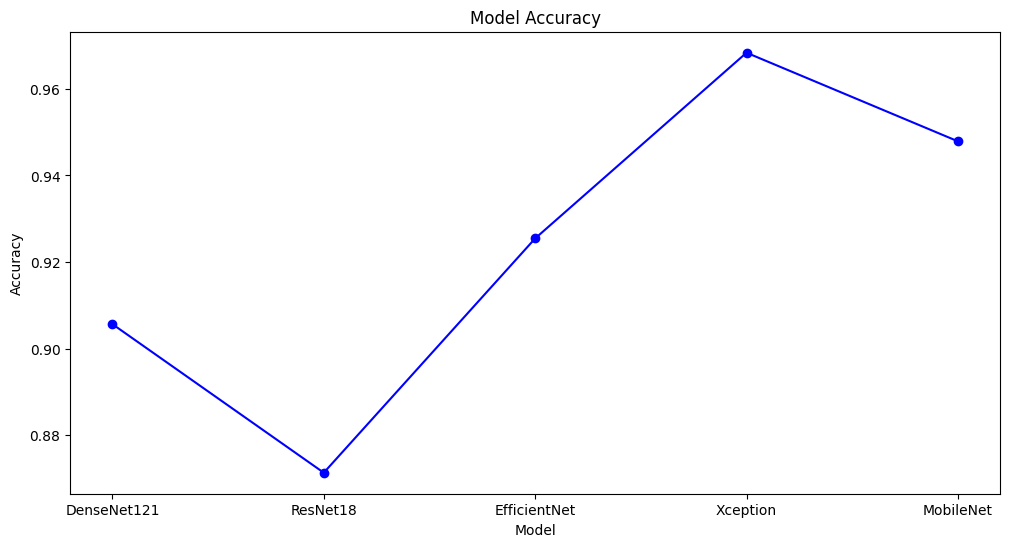

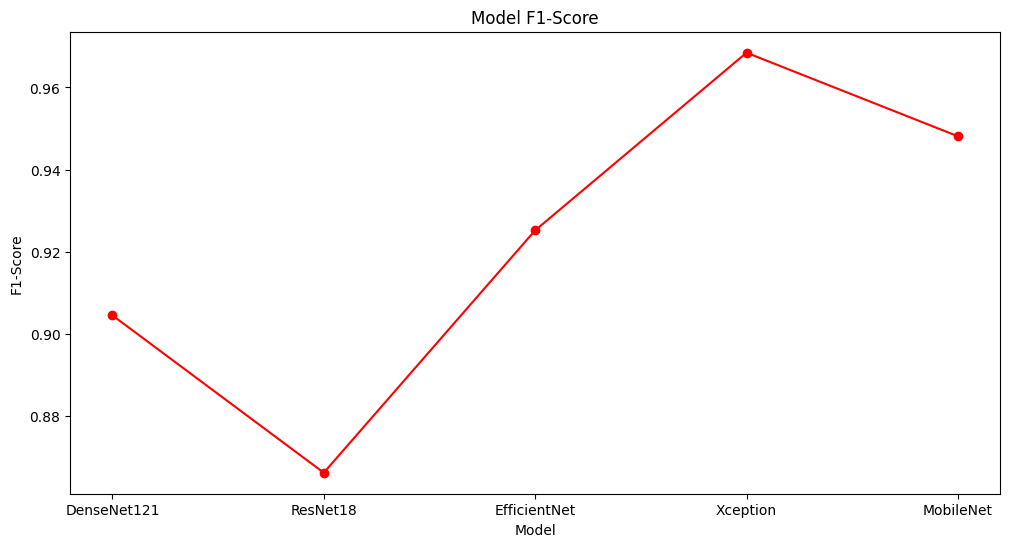

In [24]:
all_results = pd.concat([df_results_densenet, df_results_resnet, df_results_efficientnet,
                        df_results_xception,
                        df_results_mobilenet])

# Plotting the metrics
plt.figure(figsize=(12, 6))
plt.plot(all_results['Model'], all_results['Accuracy'], marker='o', linestyle='-', color='b')
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(all_results['Model'], all_results['F1-Score'], marker='o', linestyle='-', color='r')
plt.title('Model F1-Score')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.show()